# Neural Networks for Time Series Forecasting
## From MLPs to RNNs, LSTMs, and GRUs

**Topics:** Multi-Layer Perceptrons, Recurrent Neural Networks, Long Short-Term Memory, Gated Recurrent Units

---

### Learning Objectives
1. Understand how different neural architectures handle time series data
2. Compare windowed (MLP) vs sequential (RNN/LSTM/GRU) approaches
3. Learn when to use each architecture for forecasting problems
4. Hands-on implementation and performance comparison

---
## Section 1: Setup and Data Preparation

Let's start by importing our libraries and loading historical stock price data.

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

import yfinance as yf

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Setup device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("Running on CPU (GPU not available)")

Libraries imported successfully
PyTorch version: 2.9.0+cu126
Device: cuda
GPU: NVIDIA GeForce RTX 4080 Laptop GPU
CUDA version: 12.6


### Load Stock Price Data

In [226]:
# Download stock data using yfinance
# Using Apple (AAPL) as an example - you can change the ticker
TICKER = "AAPL"
df = yf.download(TICKER, start="2018-01-01", end="2024-01-01", progress=False)

# Flatten MultiIndex columns if present (yfinance sometimes returns this)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df = df.reset_index()
df = df.rename(columns={"Date": "date", "Close": "price"})
df = df[["date", "price"]].copy()
df['date'] = pd.to_datetime(df['date'])
df['price'] = df['price'].astype(float)  # Ensure price is float, not Series
df = df.sort_values('date').reset_index(drop=True)

print(f"Downloaded {len(df)} trading days of {TICKER} stock data")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")

Downloaded 1509 trading days of AAPL stock data
Date range: 2018-01-02 to 2023-12-29


C:\Users\TimPr\AppData\Local\Temp\ipykernel_38680\3383423529.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start="2018-01-01", end="2024-01-01", progress=False)


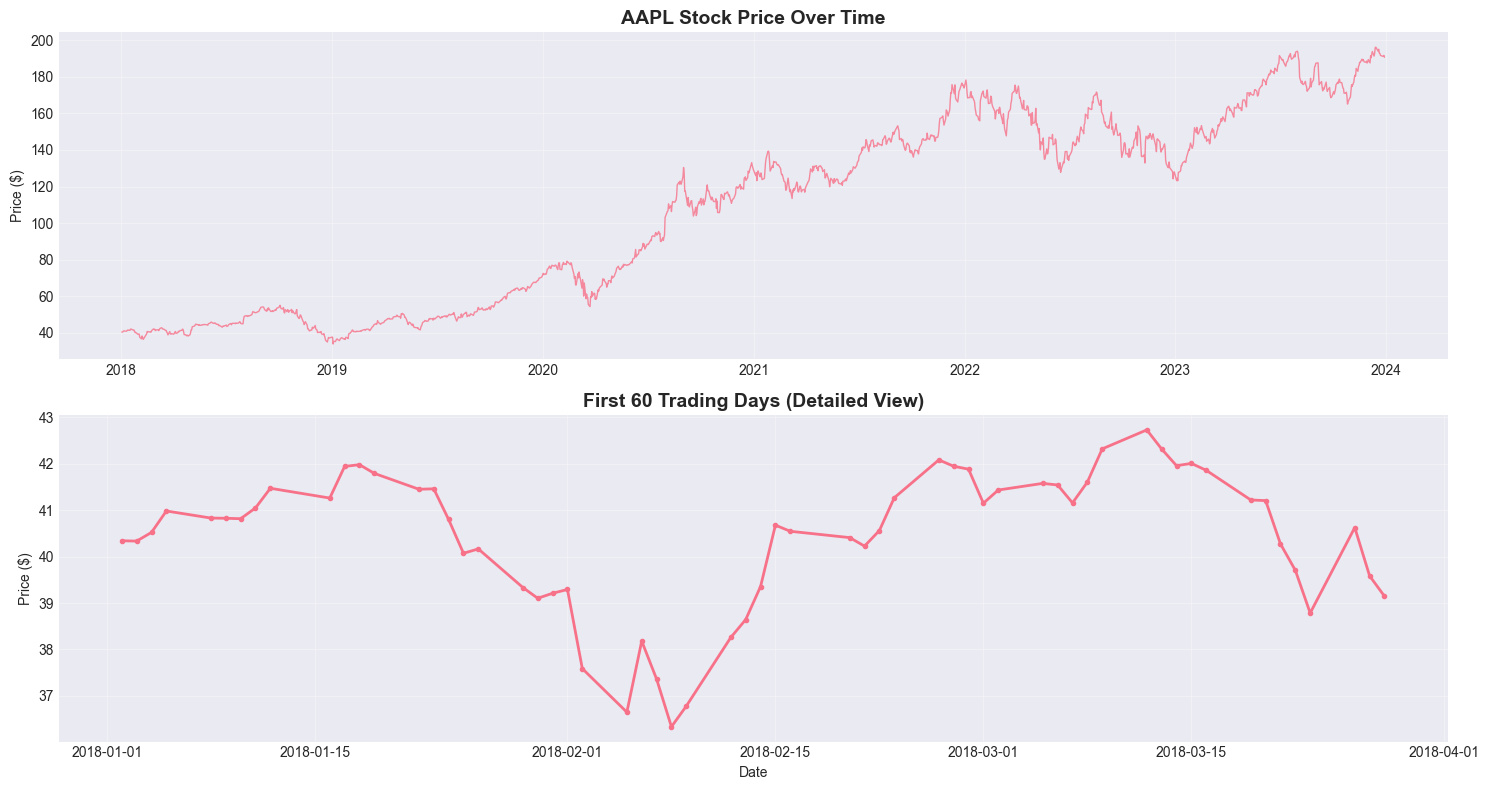

Price statistics:
  Mean: $107.82
  Std:  $50.93
  Min:  $33.80
  Max:  $196.26


In [227]:
# Visualize the stock price time series
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Full time series
axes[0].plot(df['date'], df['price'], linewidth=1, alpha=0.8)
axes[0].set_title(f'{TICKER} Stock Price Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

# Zoom into first 60 trading days
axes[1].plot(df['date'][:60], df['price'][:60], linewidth=2, marker='o', markersize=3)
axes[1].set_title('First 60 Trading Days (Detailed View)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price ($)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Price statistics:")
print(f"  Mean: ${float(df['price'].mean()):.2f}")
print(f"  Std:  ${float(df['price'].std()):.2f}")
print(f"  Min:  ${float(df['price'].min()):.2f}")
print(f"  Max:  ${float(df['price'].max()):.2f}")

### Prepare Data for Training

**Critical for time series:**
-  **Chronological split** (not random!)
-  **Scale on training data only** (prevent data leakage)
-  **Create sequences** for models

In [228]:
# Train/Val/Test split (70/15/15)
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))

train_data = df['price'].values[:train_size]
val_data = df['price'].values[train_size:train_size + val_size]
test_data = df['price'].values[train_size + val_size:]

print(f"Train set: {len(train_data)} trading days")
print(f"Val set:   {len(val_data)} trading days")
print(f"Test set:  {len(test_data)} trading days")

# Scale data (fit scaler on training data only!)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
val_scaled = scaler.transform(val_data.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()

print("\nData scaled successfully")

Train set: 1056 trading days
Val set:   226 trading days
Test set:  227 trading days

Data scaled successfully


In [229]:
def create_sequences(data, seq_length, forecast_horizon=1):
    """
    Create sequences for time series forecasting.
    
    Args:
        data: input time series
        seq_length: number of past timesteps to use
        forecast_horizon: number of future timesteps to predict
    
    Returns:
        X: sequences of shape (n_samples, seq_length)
        y: targets of shape (n_samples, forecast_horizon)
    """
    X, y = [], []
    
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + forecast_horizon])
    
    return np.array(X), np.array(y)

# Parameters for stock price prediction
SEQ_LENGTH = 100  # Use 100 trading days (~5 months) of history
FORECAST_HORIZON = 25  # Predict next 25 trading days (~5 weeks)
BATCH_SIZE = 32

# Create sequences
X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH, FORECAST_HORIZON)
X_val, y_val = create_sequences(val_scaled, SEQ_LENGTH, FORECAST_HORIZON)
X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH, FORECAST_HORIZON)

print(f"\nSequence shapes:")
print(f"X_train: {X_train.shape} (samples, seq_length)")
print(f"y_train: {y_train.shape} (samples, forecast_horizon)")
print(f"\nInterpretation: Use {SEQ_LENGTH} past trading days to predict next {FORECAST_HORIZON} trading days")


Sequence shapes:
X_train: (932, 100) (samples, seq_length)
y_train: (932, 25) (samples, forecast_horizon)

Interpretation: Use 100 past trading days to predict next 25 trading days


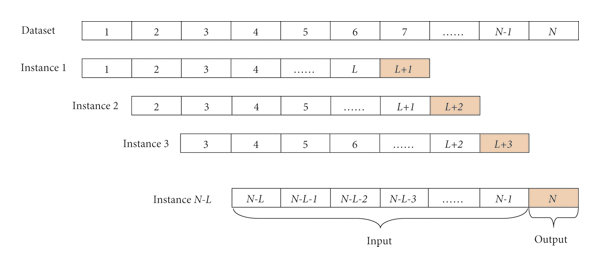

---
## Section 2: Multi-Layer Perceptrons (MLPs) for Time Series

### The Windowed Approach

MLPs treat time series as:
- **Input:** Fixed window of past values [t-60, t-59, ..., t-1] (60 trading days of price data)
- **Output:** Future value(s) [t, t+1, ..., t+4] (next 5 trading days)


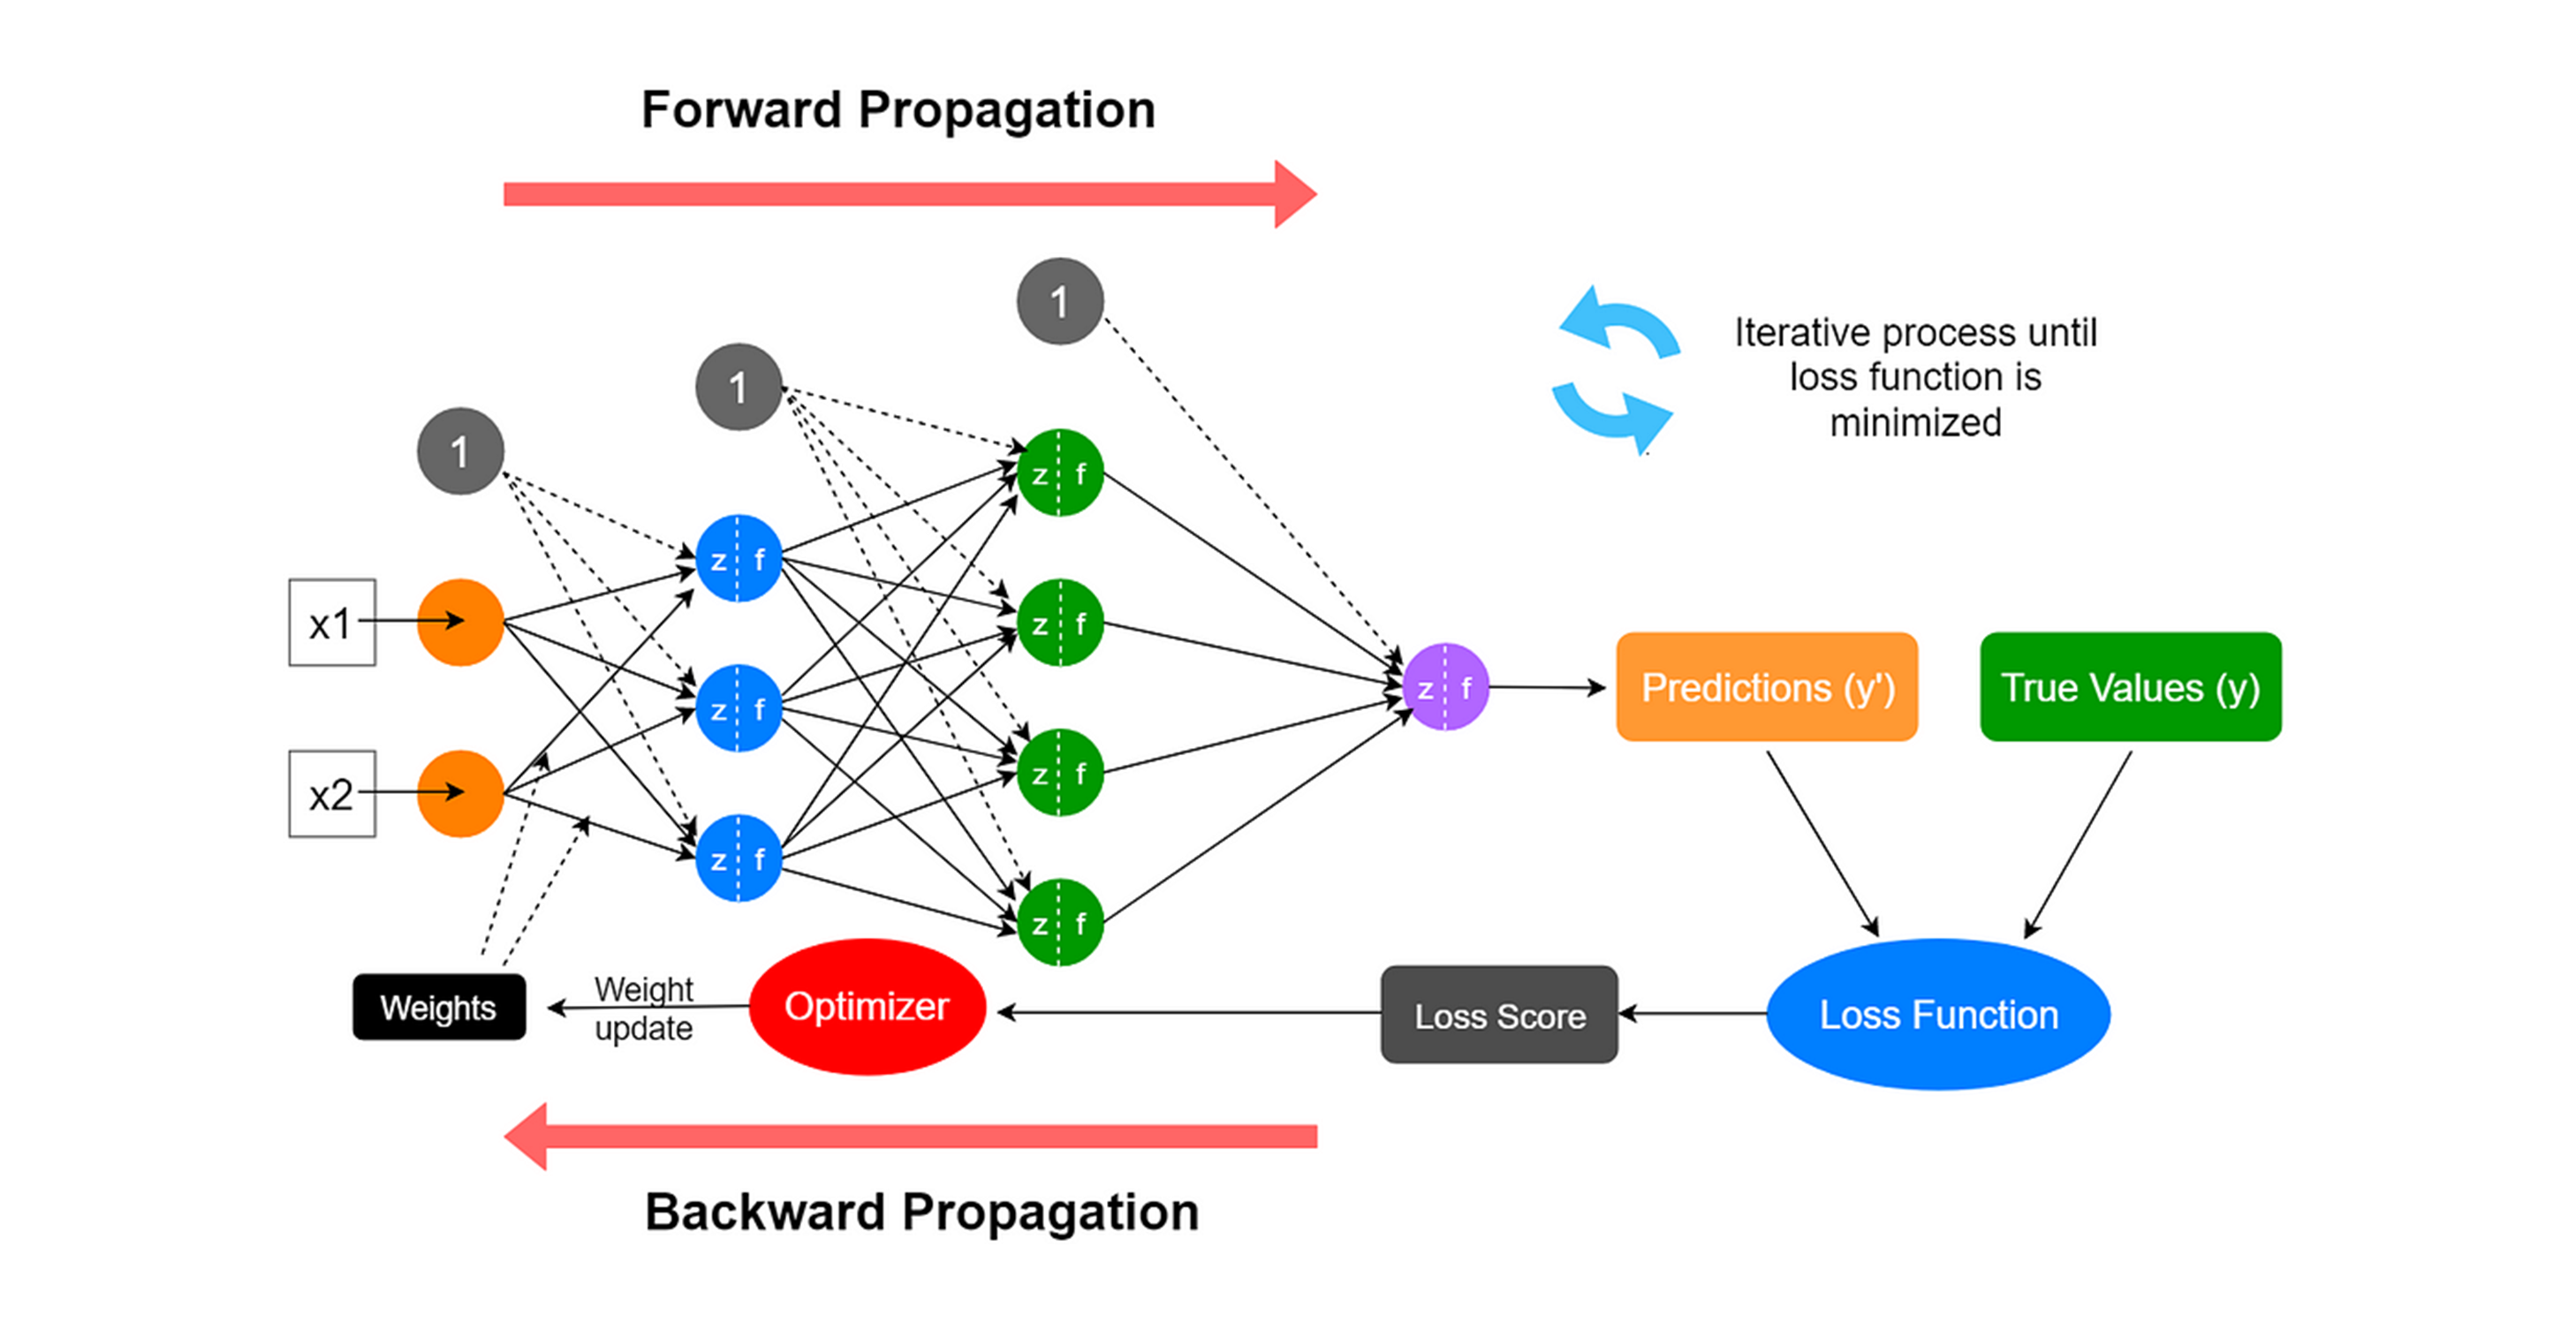
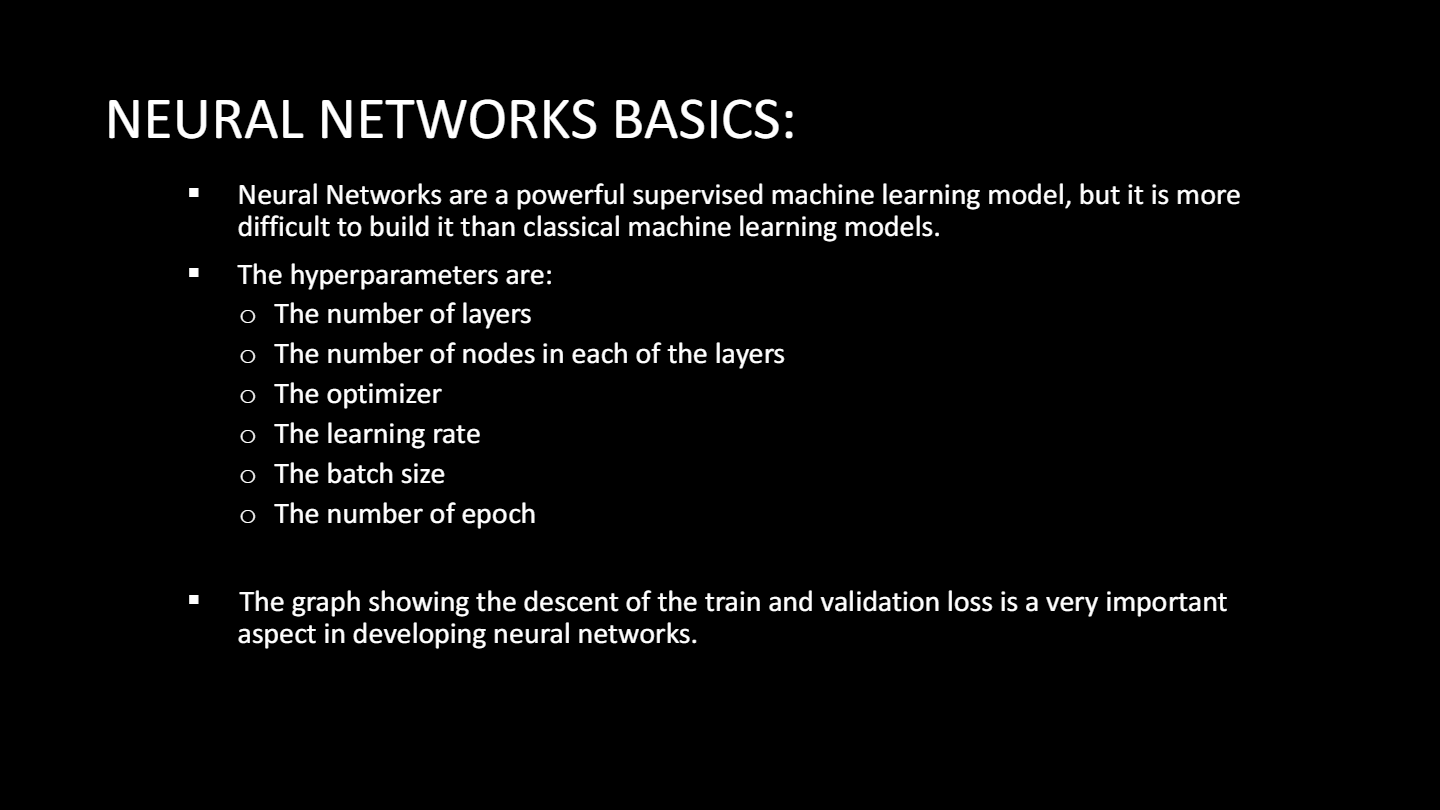


**Pros:**
-  Simple and fast (compared to other NNs)
-  Works well for short-term patterns



**Cons:**
-  No explicit temporal modeling
-  Fixed window size
-  Order doesn't matter to the network

In [230]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(MLP, self).__init__()
        
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.2))
        
        # Hidden layers (num_layers - 1 additional layers)
        current_size = hidden_size
        for i in range(num_layers - 1):
            next_size = current_size // 2
            if next_size < output_size:
                next_size = output_size
            layers.append(nn.Linear(current_size, next_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            current_size = next_size
        
        # Output layer
        layers.append(nn.Linear(current_size, output_size))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Initialize model
mlp_model = MLP(input_size=SEQ_LENGTH, hidden_size=64, output_size=FORECAST_HORIZON, num_layers=2)
print(summary(mlp_model, input_size=(1, SEQ_LENGTH)))  # (batch_size, input_features)
print(f"\nTotal parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 25]                   --
├─Sequential: 1-1                        [1, 25]                   --
│    └─Linear: 2-1                       [1, 64]                   6,464
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Dropout: 2-3                      [1, 64]                   --
│    └─Linear: 2-4                       [1, 32]                   2,080
│    └─ReLU: 2-5                         [1, 32]                   --
│    └─Dropout: 2-6                      [1, 32]                   --
│    └─Linear: 2-7                       [1, 25]                   825
Total params: 9,369
Trainable params: 9,369
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04

Total parameters: 9,369


In [231]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=5, lr=0.001, batch_size=32):
    """
    SIMPLE training function - back to basics!
    """
    # Move model to device
    model = model.to(device)
    
    # Convert to PyTorch tensors and move to device
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).to(device)
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.FloatTensor(y_val).to(device)
    
    # Create DataLoader
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Setup training - SIMPLE
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()

            optimizer.step()
            epoch_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = criterion(val_pred, y_val_t).item()
        
        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss)
        
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    
    return train_losses, val_losses

In [232]:
def evaluate_model(model, X_test, y_test, scaler, model_name="Model"):
    """
    Evaluate model and compute metrics (GPU-enabled)
    """
    model.eval()
    model = model.to(device)
    
    with torch.no_grad():
        X_test_t = torch.FloatTensor(X_test).to(device)
        predictions = model(X_test_t).cpu().numpy()
    
    # Inverse transform
    y_test_actual = scaler.inverse_transform(y_test)
    predictions_actual = scaler.inverse_transform(predictions)
    
    # Compute metrics for each forecast horizon
    rmse_per_horizon = []
    mae_per_horizon = []
    
    for h in range(y_test.shape[1]):
        rmse = np.sqrt(mean_squared_error(y_test_actual[:, h], predictions_actual[:, h]))
        mae = mean_absolute_error(y_test_actual[:, h], predictions_actual[:, h])
        rmse_per_horizon.append(rmse)
        mae_per_horizon.append(mae)
    
    print(f"\n{model_name} Test Results:")
    print(f"  Average RMSE: ${np.mean(rmse_per_horizon):.3f}")
    print(f"  Average MAE:  ${np.mean(mae_per_horizon):.3f}")
    
    return predictions_actual, y_test_actual, rmse_per_horizon, mae_per_horizon

---
## Hyperparameter Tuning

Before training our final models, let's perform a **grid search** to find optimal hyperparameters for each architecture.

**Key hyperparameters we'll tune:**
- `hidden_size`: Number of neurons in hidden layers (32, 64, 128)
- `num_layers`: Depth of the network (1, 2)
- `learning_rate`: Step size for optimization (0.001, 0.0005, 0.0001)

**Strategy:**
1. Train each configuration for a few epochs
2. Select based on **validation loss** (not test!)
3. Retrain best model for full epochs

In [233]:
class PyTorchEstimator(BaseEstimator, RegressorMixin):
    """
    Simple sklearn-compatible wrapper for PyTorch models.
    Enables use with GridSearchCV without external libraries.
    """
    def __init__(self, model_class, input_size=1, output_size=1, 
                 hidden_size=64, num_layers=2, lr=0.001, epochs=5, batch_size=32):
        self.model_class = model_class
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.model_ = None
    
    def fit(self, X, y):
        # Create fresh model instance
        self.model_ = self.model_class(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            output_size=self.output_size
        ).to(device)
        
        # Convert to tensors
        X_t = torch.FloatTensor(X).to(device)
        y_t = torch.FloatTensor(y).to(device)
        
        # Training setup
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model_.parameters(), lr=self.lr)
        dataset = TensorDataset(X_t, y_t)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Train
        self.model_.train()
        for epoch in range(self.epochs):
            for batch_X, batch_y in loader:
                optimizer.zero_grad()
                pred = self.model_(batch_X)
                loss = criterion(pred, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model_.parameters(), max_norm=1.0)
                optimizer.step()
        
        return self
    
    def predict(self, X):
        self.model_.eval()
        with torch.no_grad():
            X_t = torch.FloatTensor(X).to(device)
            predictions = self.model_(X_t).cpu().numpy()
        return predictions
    
    def score(self, X, y):
        # Return negative MSE (sklearn maximizes scores)
        predictions = self.predict(X)
        return -mean_squared_error(y, predictions)


def run_gridsearch(model_class, param_grid, X_train, y_train, model_name="Model", 
                   max_epochs=5, is_mlp=False):
    """
    Run GridSearchCV for PyTorch models using sklearn's GridSearchCV.
    """
    # Determine input size
    input_size = SEQ_LENGTH if is_mlp else 1
    
    # Create base estimator
    base_estimator = PyTorchEstimator(
        model_class=model_class,
        input_size=input_size,
        output_size=FORECAST_HORIZON,
        epochs=max_epochs
    )
    
    # Run GridSearchCV
    print(f"\n{'='*60}")
    print(f"GridSearchCV: {model_name}")
    print(f"{'='*60}")
    n_combinations = np.prod([len(v) for v in param_grid.values()])
    print(f"Testing {n_combinations} configurations with 3-fold CV...")
    
    grid_search = GridSearchCV(
        base_estimator, 
        param_grid, 
        cv=3,
        scoring='neg_mean_squared_error',
        refit=True,
        verbose=1,
        n_jobs=1
    )
    
    grid_search.fit(X_train.astype(np.float32), y_train.astype(np.float32))
    
    print(f"\nBest configuration: {grid_search.best_params_}")
    print(f"Best CV score (neg MSE): {grid_search.best_score_:.4f}")
    
    return grid_search.best_params_, grid_search


# Define hyperparameter grids
mlp_param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'lr': [0.001, 0.0005, 0.0001]
}

rnn_param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'lr': [0.001, 0.0005, 0.0001]
}

lstm_param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'lr': [0.001, 0.0005, 0.0001]
}

gru_param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'lr': [0.001, 0.0005, 0.0001]
}

print("GridSearchCV parameter grids defined:")
print(f"  MLP:  {len(mlp_param_grid['hidden_size']) * len(mlp_param_grid['num_layers']) * len(mlp_param_grid['lr'])} combinations x 3 folds")
print(f"  RNN:  {len(rnn_param_grid['hidden_size']) * len(rnn_param_grid['num_layers']) * len(rnn_param_grid['lr'])} combinations x 3 folds")
print(f"  LSTM: {len(lstm_param_grid['hidden_size']) * len(lstm_param_grid['num_layers']) * len(lstm_param_grid['lr'])} combinations x 3 folds")
print(f"  GRU:  {len(gru_param_grid['hidden_size']) * len(gru_param_grid['num_layers']) * len(gru_param_grid['lr'])} combinations x 3 folds")

GridSearchCV parameter grids defined:
  MLP:  27 combinations x 3 folds
  RNN:  18 combinations x 3 folds
  LSTM: 18 combinations x 3 folds
  GRU:  18 combinations x 3 folds


In [234]:
# Run GridSearchCV for MLP
best_mlp_params, mlp_grid = run_gridsearch(
    MLP, mlp_param_grid, X_train, y_train, 
    model_name="MLP", max_epochs=5, is_mlp=True
)

# Create optimized MLP model with best parameters
mlp_model = MLP(
    input_size=SEQ_LENGTH, 
    hidden_size=best_mlp_params['hidden_size'], 
    output_size=FORECAST_HORIZON,
    num_layers=best_mlp_params['num_layers']
)

print(f"\nOptimized MLP created: hidden_size={best_mlp_params['hidden_size']}, layers={best_mlp_params['num_layers']}, lr={best_mlp_params['lr']}")


GridSearchCV: MLP
Testing 27 configurations with 3-fold CV...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best configuration: {'hidden_size': 128, 'lr': 0.0005, 'num_layers': 1}
Best CV score (neg MSE): -0.0587

Optimized MLP created: hidden_size=128, layers=1, lr=0.0005


In [235]:
# Train MLP with best hyperparameters
print("Training MLP with optimized hyperparameters...\n")
mlp_train_losses, mlp_val_losses = train_model(
    mlp_model, X_train, y_train, X_val, y_val, 
    epochs=5, lr=best_mlp_params['lr']
)

Training MLP with optimized hyperparameters...

Epoch [1/5] - Train Loss: 0.1672, Val Loss: 0.1123
Epoch [2/5] - Train Loss: 0.0437, Val Loss: 0.1085
Epoch [3/5] - Train Loss: 0.0358, Val Loss: 0.0978
Epoch [4/5] - Train Loss: 0.0306, Val Loss: 0.0883
Epoch [5/5] - Train Loss: 0.0248, Val Loss: 0.0867



MLP Test Results:
  Average RMSE: $19.172
  Average MAE:  $17.183


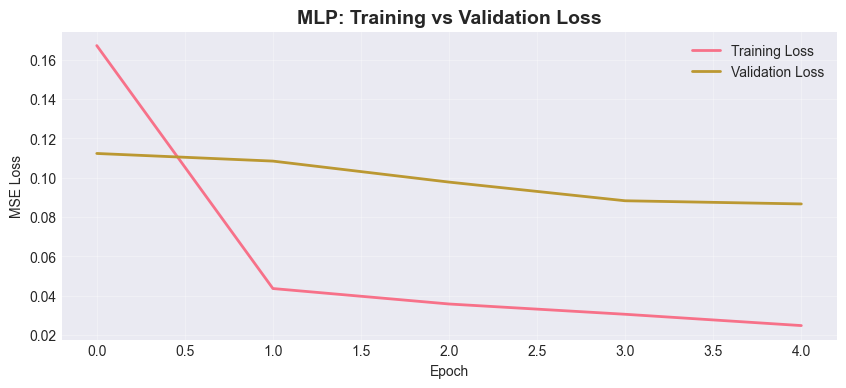

In [236]:
# Evaluate MLP
mlp_preds, mlp_actuals, mlp_rmse, mlp_mae = evaluate_model(mlp_model, X_test, y_test, scaler, "MLP")

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(mlp_train_losses, label='Training Loss', linewidth=2)
plt.plot(mlp_val_losses, label='Validation Loss', linewidth=2)
plt.title('MLP: Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

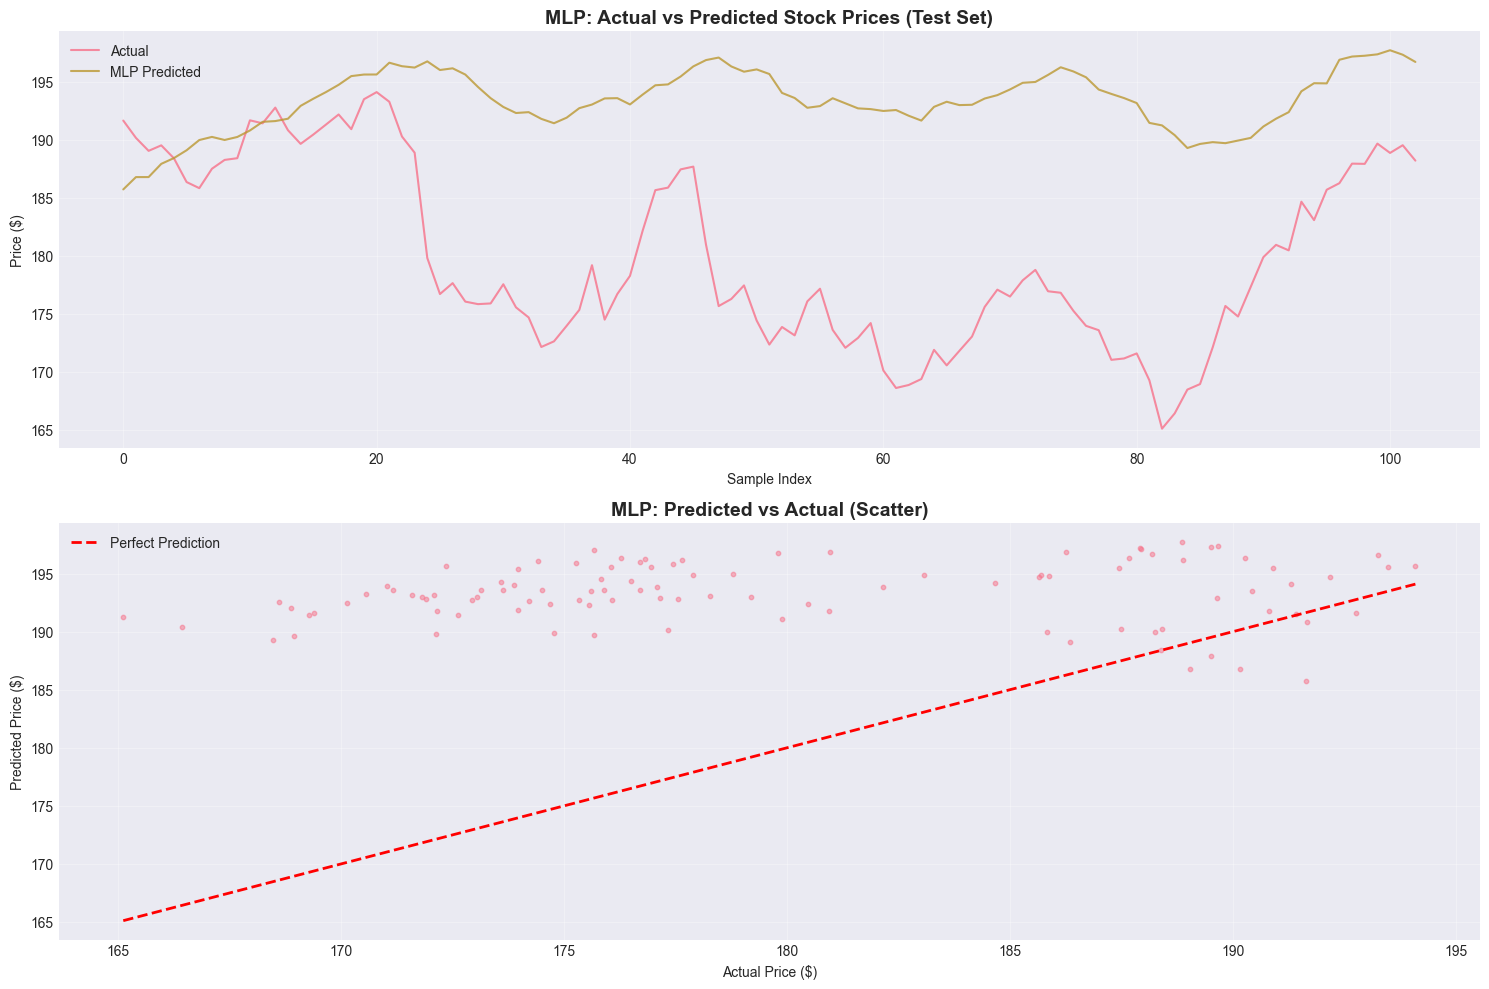


MLP Correlation (Actual vs Predicted): 0.0931


In [237]:
# Visualize MLP predictions - Actual vs Predicted on test set
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Use first prediction for each sample (1-day ahead) to create a continuous series
mlp_pred_series = mlp_preds[:, 0]  # First day prediction
mlp_actual_series = mlp_actuals[:, 0]  # Corresponding actual

# Plot actual vs predicted over time
axes[0].plot(mlp_actual_series, label='Actual', linewidth=1.5, alpha=0.8)
axes[0].plot(mlp_pred_series, label='MLP Predicted', linewidth=1.5, alpha=0.8)
axes[0].set_title('MLP: Actual vs Predicted Stock Prices (Test Set)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot: Predicted vs Actual
axes[1].scatter(mlp_actual_series, mlp_pred_series, alpha=0.5, s=10)
axes[1].plot([mlp_actual_series.min(), mlp_actual_series.max()], 
             [mlp_actual_series.min(), mlp_actual_series.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title('MLP: Predicted vs Actual (Scatter)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Predicted Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = np.corrcoef(mlp_actual_series, mlp_pred_series)[0, 1]
print(f"\nMLP Correlation (Actual vs Predicted): {correlation:.4f}")

### Discussion Point

**Question for students:** What happens if we shuffle the input sequence [t-30, t-29, ..., t-1]? Would the MLP care?



**Answer:** No! MLPs treat each timestep as an independent feature. The temporal order is lost.

**This motivates RNNs** - We need architectures that understand time!

---
## Section 3: Recurrent Neural Networks (RNNs)

### Why RNNs?

RNNs process sequences **one timestep at a time**, maintaining a **hidden state** that captures information from previous timesteps.

**Key concept:** Hidden state = memory of what the network has seen so far

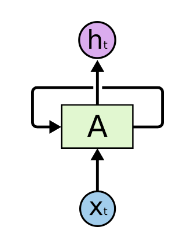



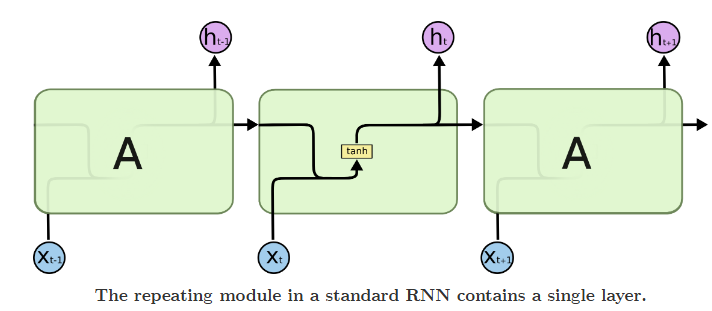

$$
\begin{aligned}
h_t &= \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h) \\
y_t &= W_{hy} h_t + b_y
\end{aligned}
$$

## tanh Function:

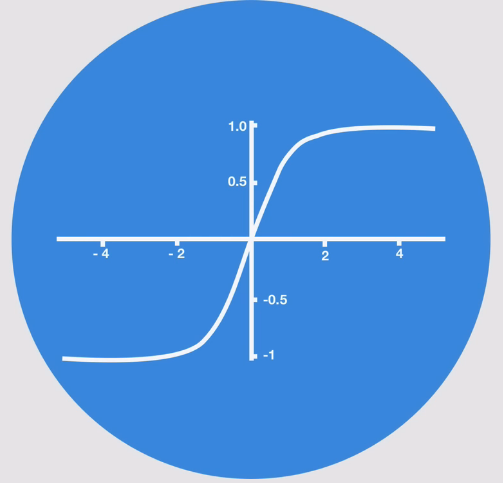

---
## Exercise 1: RNN vs MLP Comparison

Let's implement an RNN and compare it directly with our MLP!

In [238]:
class RNNForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=168, num_layers=2, output_size=7):
        super(RNNForecaster, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch, seq_len)
        # Reshape to (batch, seq_len, features)
        x = x.unsqueeze(-1)
        
        # RNN forward pass
        # out shape: (batch, seq_len, hidden_size)
        # h_n shape: (num_layers, batch, hidden_size)
        out, h_n = self.rnn(x)
        
        # Use the last hidden state
        # out[:, -1, :] gets the last timestep's output
        last_hidden = out[:, -1, :]
        
        # Predict future values
        predictions = self.fc(last_hidden)
        return predictions

# Initialize RNN
rnn_model = RNNForecaster(input_size=1, hidden_size=64, num_layers=2, output_size=FORECAST_HORIZON)
print(summary(rnn_model, input_size=(1,1)))
print(f"\nTotal parameters: {sum(p.numel() for p in rnn_model.parameters()):,}")

Layer (type:depth-idx)                   Output Shape              Param #
RNNForecaster                            [1, 25]                   --
├─RNN: 1-1                               [1, 1, 64]                12,608
├─Linear: 1-2                            [1, 25]                   1,625
Total params: 14,233
Trainable params: 14,233
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06

Total parameters: 14,233


In [239]:
# Run GridSearchCV for RNN
best_rnn_params, rnn_grid = run_gridsearch(
    RNNForecaster, rnn_param_grid, X_train, y_train, 
    model_name="RNN", max_epochs=5, is_mlp=False
)

# Create optimized RNN model with best parameters
rnn_model = RNNForecaster(
    input_size=1, 
    hidden_size=best_rnn_params['hidden_size'], 
    num_layers=best_rnn_params['num_layers'],
    output_size=FORECAST_HORIZON
)

print(f"\nOptimized RNN created: hidden_size={best_rnn_params['hidden_size']}, layers={best_rnn_params['num_layers']}, lr={best_rnn_params['lr']}")


GridSearchCV: RNN
Testing 18 configurations with 3-fold CV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best configuration: {'hidden_size': 128, 'lr': 0.001, 'num_layers': 2}
Best CV score (neg MSE): -0.0145

Optimized RNN created: hidden_size=128, layers=2, lr=0.001


In [240]:
# Train RNN with best hyperparameters
print("Training RNN with optimized hyperparameters...\n")
rnn_train_losses, rnn_val_losses = train_model(
    rnn_model, X_train, y_train, X_val, y_val, 
    epochs=5, lr=best_rnn_params['lr']
)

Training RNN with optimized hyperparameters...

Epoch [1/5] - Train Loss: 0.1040, Val Loss: 0.0499
Epoch [2/5] - Train Loss: 0.0124, Val Loss: 0.0151
Epoch [3/5] - Train Loss: 0.0099, Val Loss: 0.0260
Epoch [4/5] - Train Loss: 0.0097, Val Loss: 0.0226
Epoch [5/5] - Train Loss: 0.0093, Val Loss: 0.0188


In [241]:
# Evaluate RNN
rnn_preds, rnn_actuals, rnn_rmse, rnn_mae = evaluate_model(rnn_model, X_test, y_test, scaler, "RNN")


RNN Test Results:
  Average RMSE: $10.045
  Average MAE:  $8.130


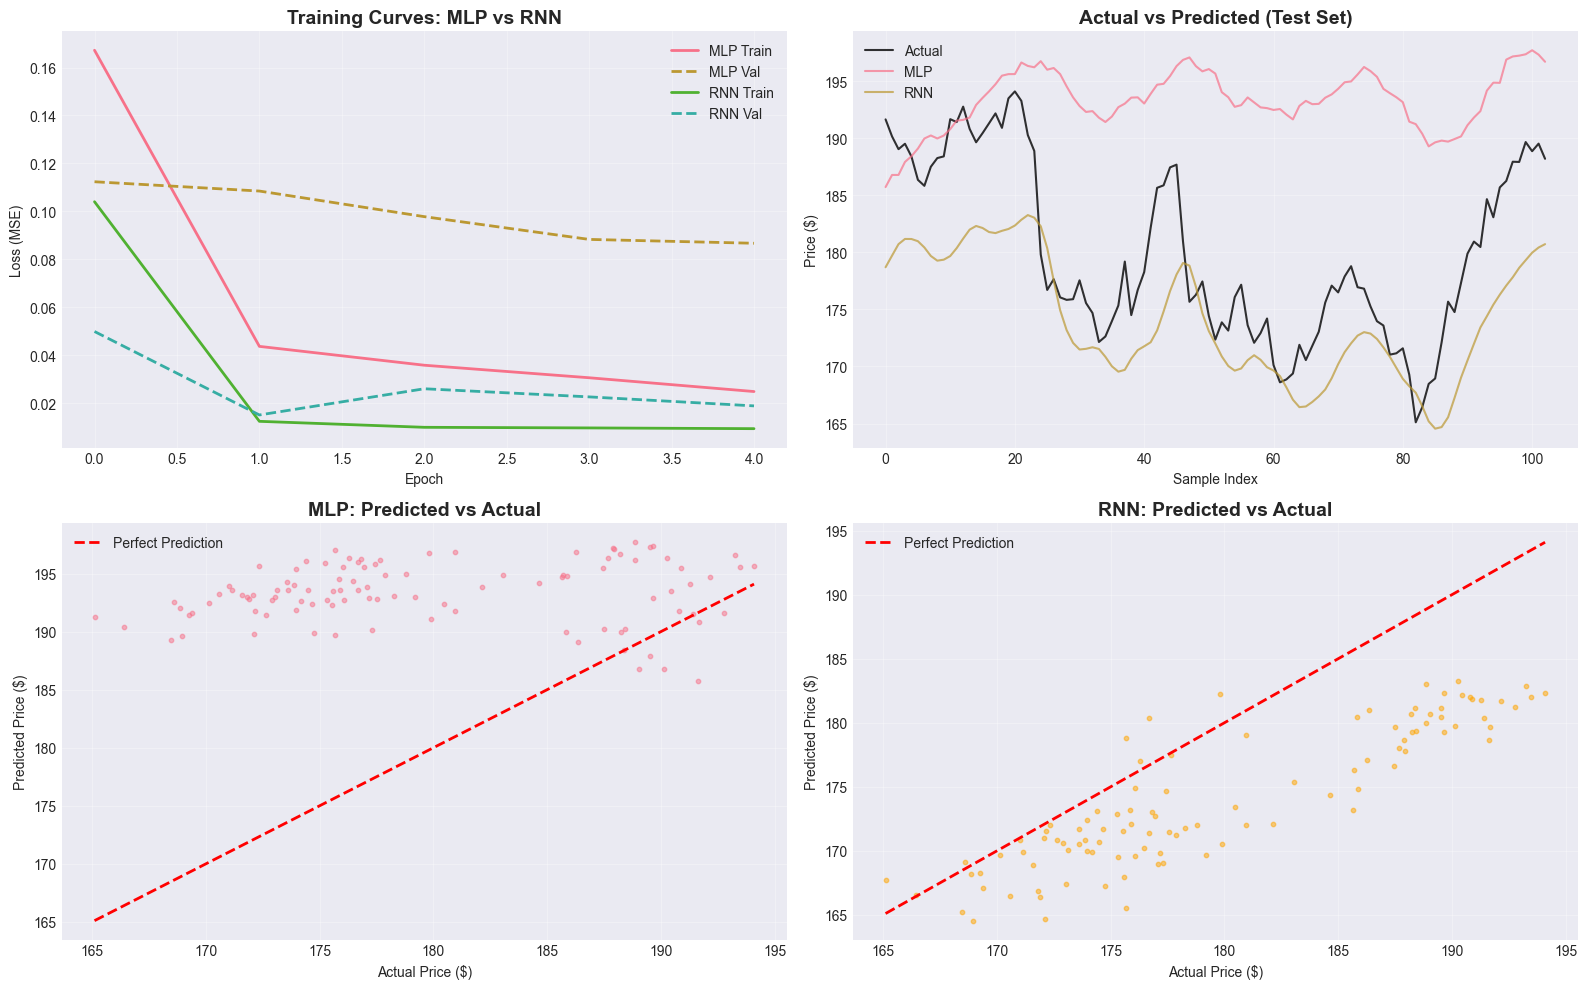


MLP vs RNN Performance Summary
Metric               MLP             RNN             Winner
------------------------------------------------------------
Avg RMSE ($)         19.172          10.045          RNN
Avg MAE ($)          17.183          8.130           RNN
Correlation          0.0931          0.8811         
Parameters           16,153          53,017         


In [242]:
# Compare MLP vs RNN - Actual vs Predicted
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Extract 1-day ahead predictions for continuous series
mlp_pred_series = mlp_preds[:, 0]
mlp_actual_series = mlp_actuals[:, 0]
rnn_pred_series = rnn_preds[:, 0]
rnn_actual_series = rnn_actuals[:, 0]

# Training curves
axes[0, 0].plot(mlp_train_losses, label='MLP Train', linewidth=2)
axes[0, 0].plot(mlp_val_losses, label='MLP Val', linewidth=2, linestyle='--')
axes[0, 0].plot(rnn_train_losses, label='RNN Train', linewidth=2)
axes[0, 0].plot(rnn_val_losses, label='RNN Val', linewidth=2, linestyle='--')
axes[0, 0].set_title('Training Curves: MLP vs RNN', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Actual vs Predicted - Both models overlaid
axes[0, 1].plot(mlp_actual_series, label='Actual', linewidth=1.5, alpha=0.8, color='black')
axes[0, 1].plot(mlp_pred_series, label='MLP', linewidth=1.5, alpha=0.7)
axes[0, 1].plot(rnn_pred_series, label='RNN', linewidth=1.5, alpha=0.7)
axes[0, 1].set_title('Actual vs Predicted (Test Set)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot - MLP
axes[1, 0].scatter(mlp_actual_series, mlp_pred_series, alpha=0.5, s=10)
axes[1, 0].plot([mlp_actual_series.min(), mlp_actual_series.max()], 
                [mlp_actual_series.min(), mlp_actual_series.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('MLP: Predicted vs Actual', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Actual Price ($)')
axes[1, 0].set_ylabel('Predicted Price ($)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot - RNN
axes[1, 1].scatter(rnn_actual_series, rnn_pred_series, alpha=0.5, s=10, color='orange')
axes[1, 1].plot([rnn_actual_series.min(), rnn_actual_series.max()], 
                [rnn_actual_series.min(), rnn_actual_series.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_title('RNN: Predicted vs Actual', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Actual Price ($)')
axes[1, 1].set_ylabel('Predicted Price ($)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("MLP vs RNN Performance Summary")
print("="*60)
print(f"{'Metric':<20} {'MLP':<15} {'RNN':<15} {'Winner'}")
print("-"*60)
print(f"{'Avg RMSE ($)':<20} {np.mean(mlp_rmse):<15.3f} {np.mean(rnn_rmse):<15.3f} {'RNN' if np.mean(rnn_rmse) < np.mean(mlp_rmse) else 'MLP'}")
print(f"{'Avg MAE ($)':<20} {np.mean(mlp_mae):<15.3f} {np.mean(rnn_mae):<15.3f} {'RNN' if np.mean(rnn_mae) < np.mean(mlp_mae) else 'MLP'}")
print(f"{'Correlation':<20} {np.corrcoef(mlp_actual_series, mlp_pred_series)[0,1]:<15.4f} {np.corrcoef(rnn_actual_series, rnn_pred_series)[0,1]:<15.4f}")
print(f"{'Parameters':<20} {sum(p.numel() for p in mlp_model.parameters()):<15,} {sum(p.numel() for p in rnn_model.parameters()):<15,}")
print("="*60)

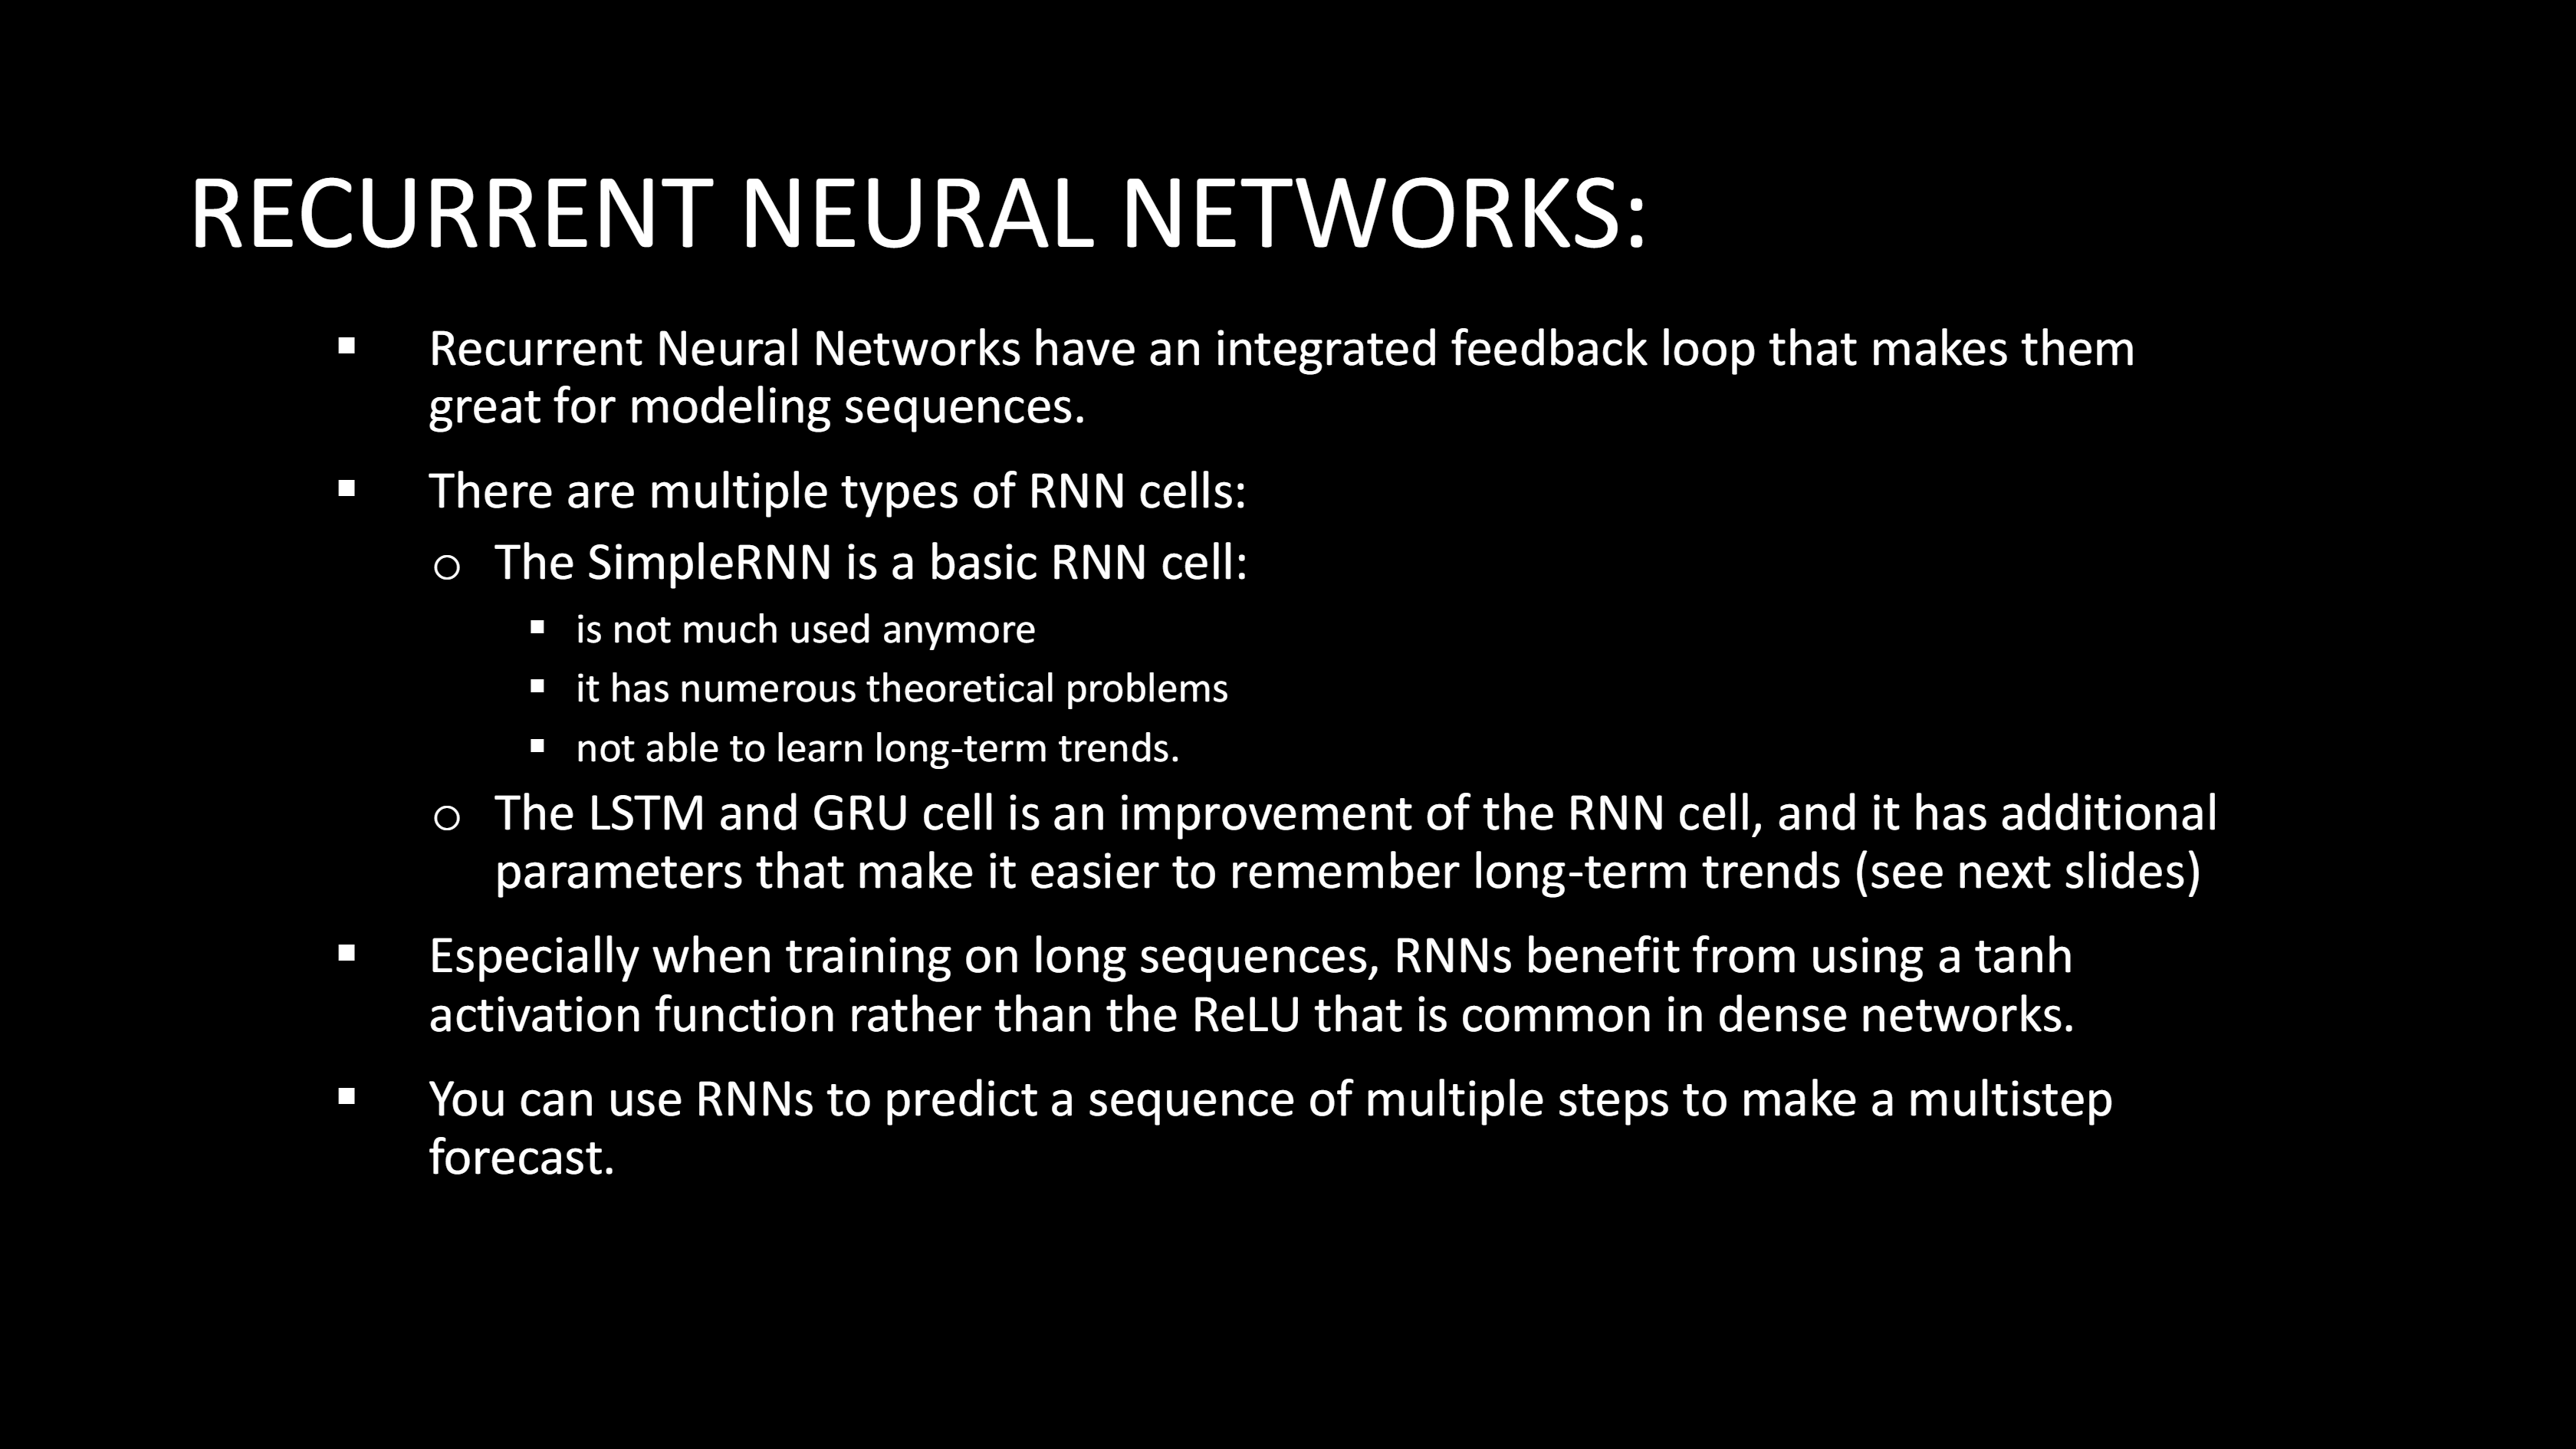

---
## Section 4: Long Short-Term Memory (LSTM) Networks

### The LSTM Architecture

LSTMs solve the vanishing gradient problem with a sophisticated **gating mechanism**:

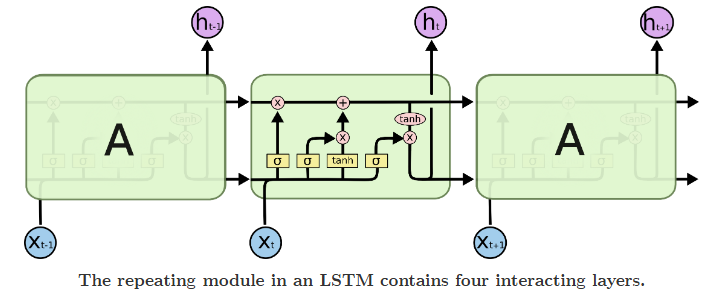



**Sigmoid activation function:**

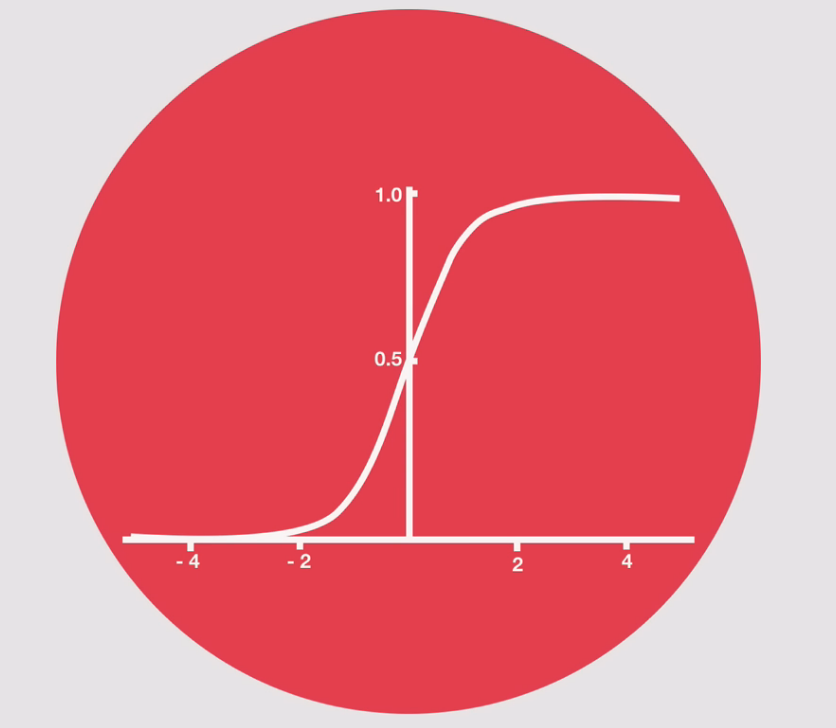


**Key innovation:** Cell state (C_t) - a highway for gradients!

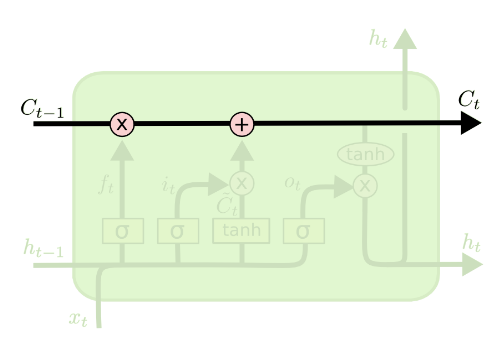

**Three gates:**
1. **Forget Gate (f):** What to discard from cell state

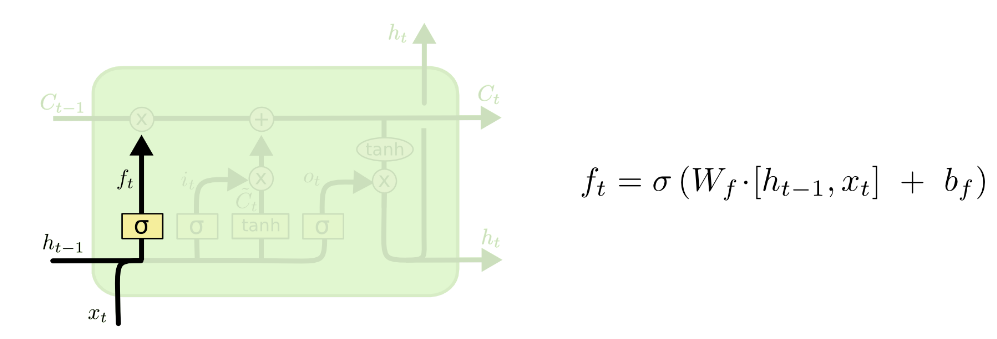


2. **Input Gate (i):** What new information to add

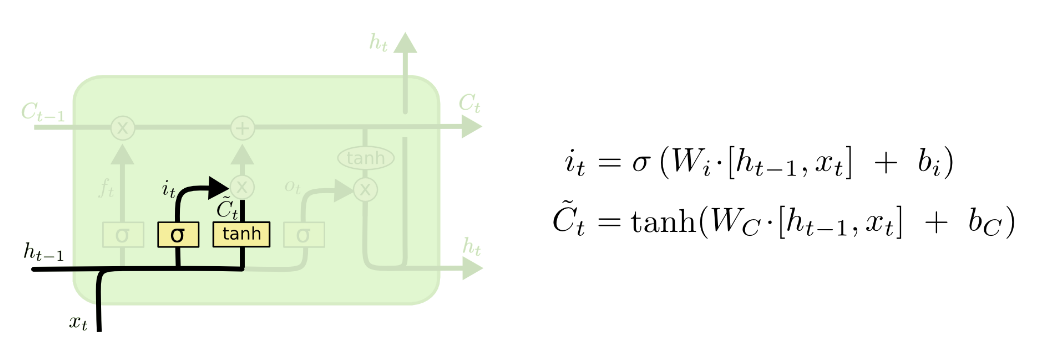
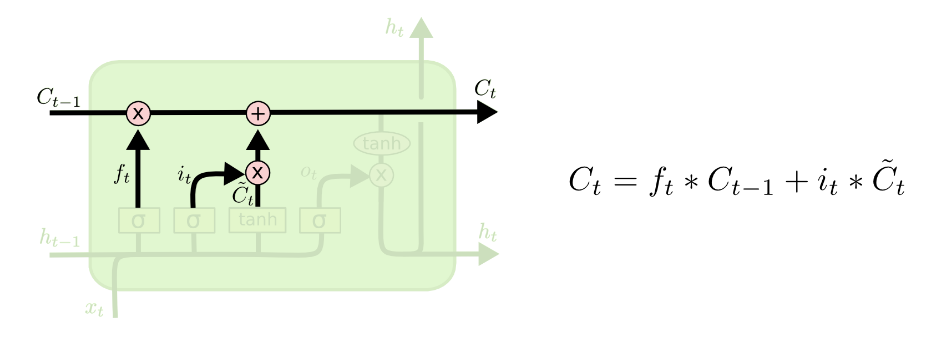


3. **Output Gate (o):** What to output based on cell state

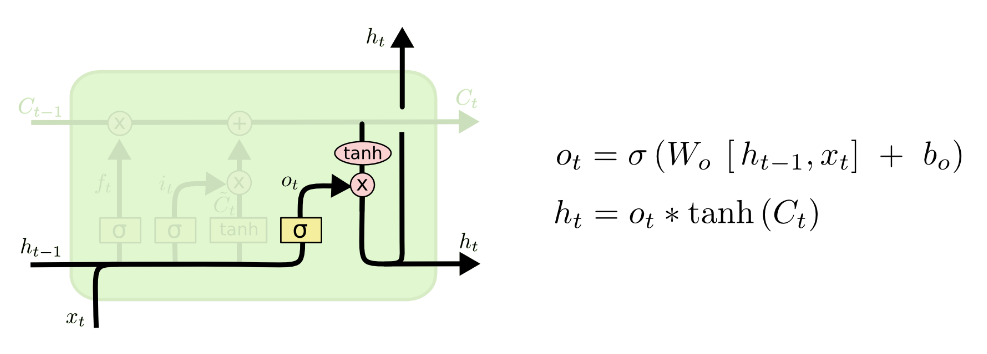


**Pros:**
- Handles long-term dependencies
- Mitigates vanishing gradients
- State-of-the-art for many sequence tasks



**Cons:**
- More parameters (slower training)
- More complex architecture

---
## Exercise 2: LSTM for Multi-Step Forecasting

Let's implement an LSTM and visualize its internal gates!

In [243]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=7):
        super(LSTMForecaster, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer - SIMPLE
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch, seq_len)
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        
        # LSTM forward
        out, (h_n, c_n) = self.lstm(x)
        
        # Use last timestep
        last_hidden = out[:, -1, :]
        
        # Predict future
        predictions = self.fc(last_hidden)
        return predictions

# Initialize LSTM - BACK TO SIMPLE
lstm_model = LSTMForecaster(input_size=1, hidden_size=64, num_layers=2, output_size=FORECAST_HORIZON)
print(lstm_model)
print(summary(lstm_model, input_size=(1,1)))
print(f"\nTotal parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")
print(f"\nNote: LSTM has ~4x parameters per layer compared to RNN (due to gates)")

LSTMForecaster(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=25, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
LSTMForecaster                           [1, 25]                   --
├─LSTM: 1-1                              [1, 1, 64]                50,432
├─Linear: 1-2                            [1, 25]                   1,625
Total params: 52,057
Trainable params: 52,057
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.21

Total parameters: 52,057

Note: LSTM has ~4x parameters per layer compared to RNN (due to gates)


In [244]:
# Run GridSearchCV for LSTM
best_lstm_params, lstm_grid = run_gridsearch(
    LSTMForecaster, lstm_param_grid, X_train, y_train, 
    model_name="LSTM", max_epochs=5, is_mlp=False
)

# Create optimized LSTM model with best parameters
lstm_model = LSTMForecaster(
    input_size=1, 
    hidden_size=best_lstm_params['hidden_size'], 
    num_layers=best_lstm_params['num_layers'],
    output_size=FORECAST_HORIZON
)

print(f"\nOptimized LSTM created: hidden_size={best_lstm_params['hidden_size']}, layers={best_lstm_params['num_layers']}, lr={best_lstm_params['lr']}")


GridSearchCV: LSTM
Testing 18 configurations with 3-fold CV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best configuration: {'hidden_size': 128, 'lr': 0.001, 'num_layers': 1}
Best CV score (neg MSE): -0.0624

Optimized LSTM created: hidden_size=128, layers=1, lr=0.001


In [245]:
# Train LSTM with best hyperparameters
print("Training LSTM with optimized hyperparameters...\n")
lstm_train_losses, lstm_val_losses = train_model(
    lstm_model, X_train, y_train, X_val, y_val, 
    epochs=5, lr=best_lstm_params['lr']
)

Training LSTM with optimized hyperparameters...

Epoch [1/5] - Train Loss: 0.2460, Val Loss: 0.1202
Epoch [2/5] - Train Loss: 0.0292, Val Loss: 0.0149
Epoch [3/5] - Train Loss: 0.0126, Val Loss: 0.0193
Epoch [4/5] - Train Loss: 0.0102, Val Loss: 0.0197
Epoch [5/5] - Train Loss: 0.0102, Val Loss: 0.0327


In [246]:
# Evaluate LSTM
lstm_preds, lstm_actuals, lstm_rmse, lstm_mae = evaluate_model(lstm_model, X_test, y_test, scaler, "LSTM")


LSTM Test Results:
  Average RMSE: $8.948
  Average MAE:  $7.684


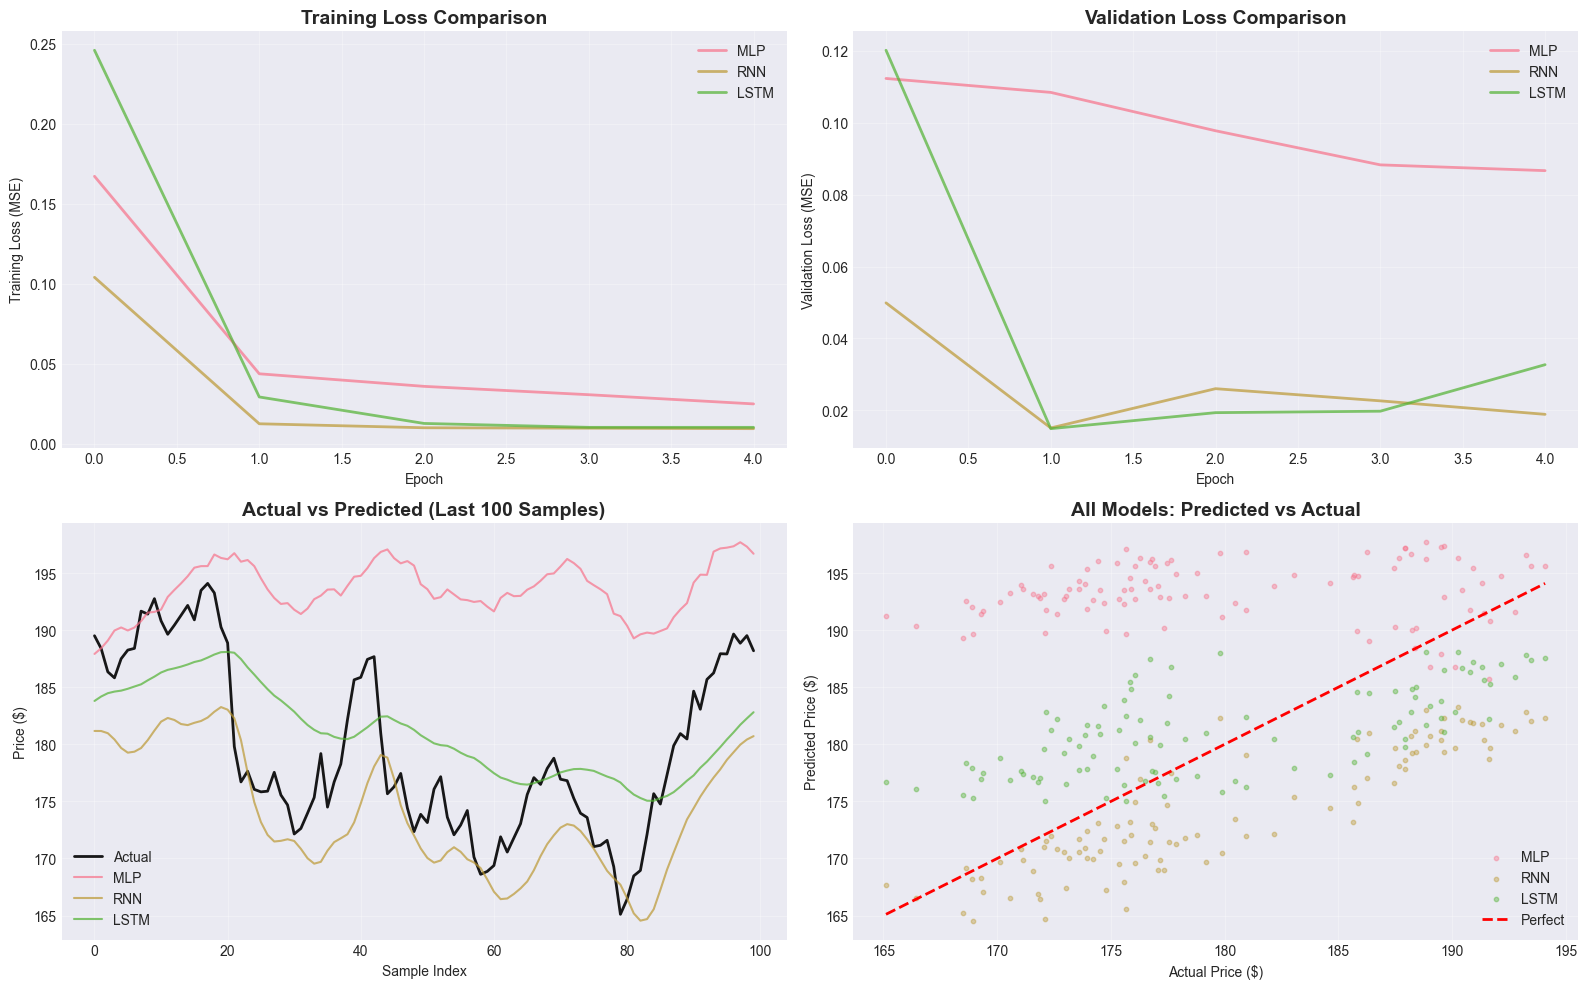


Complete Performance Comparison
Metric                    MLP             RNN             LSTM           
----------------------------------------------------------------------
Avg RMSE ($)              19.172          10.045          8.948          
Avg MAE ($)               17.183          8.130           7.684          
Correlation               0.0931          0.8811          0.6487         
Final Train Loss          0.0248          0.0093          0.0102         
Final Val Loss            0.0867          0.0188          0.0327         
Parameters                16,153          53,017          70,297         


In [247]:
# Three-way comparison: MLP vs RNN vs LSTM - Actual vs Predicted
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Extract 1-day ahead predictions
mlp_pred_series = mlp_preds[:, 0]
rnn_pred_series = rnn_preds[:, 0]
lstm_pred_series = lstm_preds[:, 0]
actual_series = lstm_actuals[:, 0]

# Training curves
axes[0, 0].plot(mlp_train_losses, label='MLP', linewidth=2, alpha=0.7)
axes[0, 0].plot(rnn_train_losses, label='RNN', linewidth=2, alpha=0.7)
axes[0, 0].plot(lstm_train_losses, label='LSTM', linewidth=2, alpha=0.7)
axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Training Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation curves
axes[0, 1].plot(mlp_val_losses, label='MLP', linewidth=2, alpha=0.7)
axes[0, 1].plot(rnn_val_losses, label='RNN', linewidth=2, alpha=0.7)
axes[0, 1].plot(lstm_val_losses, label='LSTM', linewidth=2, alpha=0.7)
axes[0, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation Loss (MSE)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Actual vs Predicted - All models (zoomed to last 100 samples for clarity)
n_show = 100
axes[1, 0].plot(actual_series[-n_show:], label='Actual', linewidth=2, alpha=0.9, color='black')
axes[1, 0].plot(mlp_pred_series[-n_show:], label='MLP', linewidth=1.5, alpha=0.7)
axes[1, 0].plot(rnn_pred_series[-n_show:], label='RNN', linewidth=1.5, alpha=0.7)
axes[1, 0].plot(lstm_pred_series[-n_show:], label='LSTM', linewidth=1.5, alpha=0.7)
axes[1, 0].set_title(f'Actual vs Predicted (Last {n_show} Samples)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Price ($)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot comparison - all models
axes[1, 1].scatter(actual_series, mlp_pred_series, alpha=0.4, s=10, label='MLP')
axes[1, 1].scatter(actual_series, rnn_pred_series, alpha=0.4, s=10, label='RNN')
axes[1, 1].scatter(actual_series, lstm_pred_series, alpha=0.4, s=10, label='LSTM')
axes[1, 1].plot([actual_series.min(), actual_series.max()], 
                [actual_series.min(), actual_series.max()], 
                'r--', linewidth=2, label='Perfect')
axes[1, 1].set_title('All Models: Predicted vs Actual', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Actual Price ($)')
axes[1, 1].set_ylabel('Predicted Price ($)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print("Complete Performance Comparison")
print("="*70)
print(f"{'Metric':<25} {'MLP':<15} {'RNN':<15} {'LSTM':<15}")
print("-"*70)
print(f"{'Avg RMSE ($)':<25} {np.mean(mlp_rmse):<15.3f} {np.mean(rnn_rmse):<15.3f} {np.mean(lstm_rmse):<15.3f}")
print(f"{'Avg MAE ($)':<25} {np.mean(mlp_mae):<15.3f} {np.mean(rnn_mae):<15.3f} {np.mean(lstm_mae):<15.3f}")
corr_mlp = np.corrcoef(actual_series, mlp_pred_series)[0, 1]
corr_rnn = np.corrcoef(actual_series, rnn_pred_series)[0, 1]
corr_lstm = np.corrcoef(actual_series, lstm_pred_series)[0, 1]
print(f"{'Correlation':<25} {corr_mlp:<15.4f} {corr_rnn:<15.4f} {corr_lstm:<15.4f}")
print(f"{'Final Train Loss':<25} {mlp_train_losses[-1]:<15.4f} {rnn_train_losses[-1]:<15.4f} {lstm_train_losses[-1]:<15.4f}")
print(f"{'Final Val Loss':<25} {mlp_val_losses[-1]:<15.4f} {rnn_val_losses[-1]:<15.4f} {lstm_val_losses[-1]:<15.4f}")
print(f"{'Parameters':<25} {sum(p.numel() for p in mlp_model.parameters()):<15,} {sum(p.numel() for p in rnn_model.parameters()):<15,} {sum(p.numel() for p in lstm_model.parameters()):<15,}")
print("="*70)

### Key Observations

1. **Training stability:** LSTMs typically have smoother training curves
2. **Long-term forecasting:** LSTMs excel at longer horizons (later days in the forecast)

### When to Use LSTMs

**Use LSTMs when:**
- Long-term dependencies are critical
- You have sufficient training data
- Forecasting far into the future (weeks/months)


---
## Section 5: Gated Recurrent Units (GRUs)

### The GRU Architecture

GRUs are a **simplified version of LSTMs** with fewer gates:

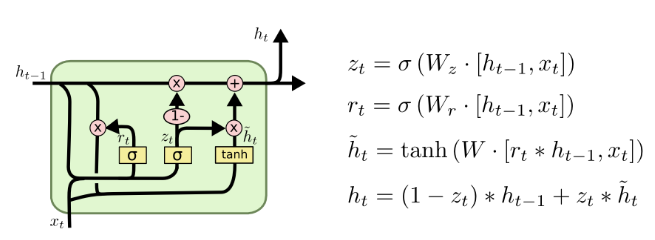

**Two gates instead of three:**
1. **Reset Gate (r):** How much past info to forget
2. **Update Gate (z):** How much to update with new info

**No separate cell state!** - Hidden state does double duty

**Pros:**
- Fewer parameters than LSTM (~25% less)
- Faster training and inference
- Often comparable performance to LSTM
- Better for smaller datasets

**Cons:**
- Slightly less expressive than LSTM
- May underperform on very long sequences

In [248]:
class GRUForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=7):
        super(GRUForecaster, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU layer
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch, seq_len)
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        
        # GRU forward
        out, h_n = self.gru(x)
        
        # Use last timestep
        last_hidden = out[:, -1, :]
        
        # Predict future
        predictions = self.fc(last_hidden)
        return predictions

# Initialize GRU
gru_model = GRUForecaster(input_size=1, hidden_size=64, num_layers=2, output_size=FORECAST_HORIZON)
print(gru_model)
print(summary(gru_model, input_size=(1,1)))
print(f"\nTotal parameters: {sum(p.numel() for p in gru_model.parameters()):,}")

GRUForecaster(
  (gru): GRU(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=25, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
GRUForecaster                            [1, 25]                   --
├─GRU: 1-1                               [1, 1, 64]                37,824
├─Linear: 1-2                            [1, 25]                   1,625
Total params: 39,449
Trainable params: 39,449
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.16

Total parameters: 39,449


In [249]:
# Run GridSearchCV for GRU
best_gru_params, gru_grid = run_gridsearch(
    GRUForecaster, gru_param_grid, X_train, y_train, 
    model_name="GRU", max_epochs=5, is_mlp=False
)

# Create optimized GRU model with best parameters
gru_model = GRUForecaster(
    input_size=1, 
    hidden_size=best_gru_params['hidden_size'], 
    num_layers=best_gru_params['num_layers'],
    output_size=FORECAST_HORIZON
)

print(f"\nOptimized GRU created: hidden_size={best_gru_params['hidden_size']}, layers={best_gru_params['num_layers']}, lr={best_gru_params['lr']}")


GridSearchCV: GRU
Testing 18 configurations with 3-fold CV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best configuration: {'hidden_size': 128, 'lr': 0.001, 'num_layers': 2}
Best CV score (neg MSE): -0.0172

Optimized GRU created: hidden_size=128, layers=2, lr=0.001


In [250]:
# Train GRU with best hyperparameters
print("Training GRU with optimized hyperparameters...\n")
gru_train_losses, gru_val_losses = train_model(
    gru_model, X_train, y_train, X_val, y_val, 
    epochs=5, lr=best_gru_params['lr']
)

Training GRU with optimized hyperparameters...

Epoch [1/5] - Train Loss: 0.1477, Val Loss: 0.0184
Epoch [2/5] - Train Loss: 0.0134, Val Loss: 0.0211
Epoch [3/5] - Train Loss: 0.0104, Val Loss: 0.0188
Epoch [4/5] - Train Loss: 0.0096, Val Loss: 0.0197
Epoch [5/5] - Train Loss: 0.0092, Val Loss: 0.0161


In [251]:
# Evaluate GRU
gru_preds, gru_actuals, gru_rmse, gru_mae = evaluate_model(gru_model, X_test, y_test, scaler, "GRU")


GRU Test Results:
  Average RMSE: $12.906
  Average MAE:  $10.512


---
## Exercise 3: GRU vs LSTM - Speed & Accuracy Trade-off

Let's benchmark GRU against LSTM!

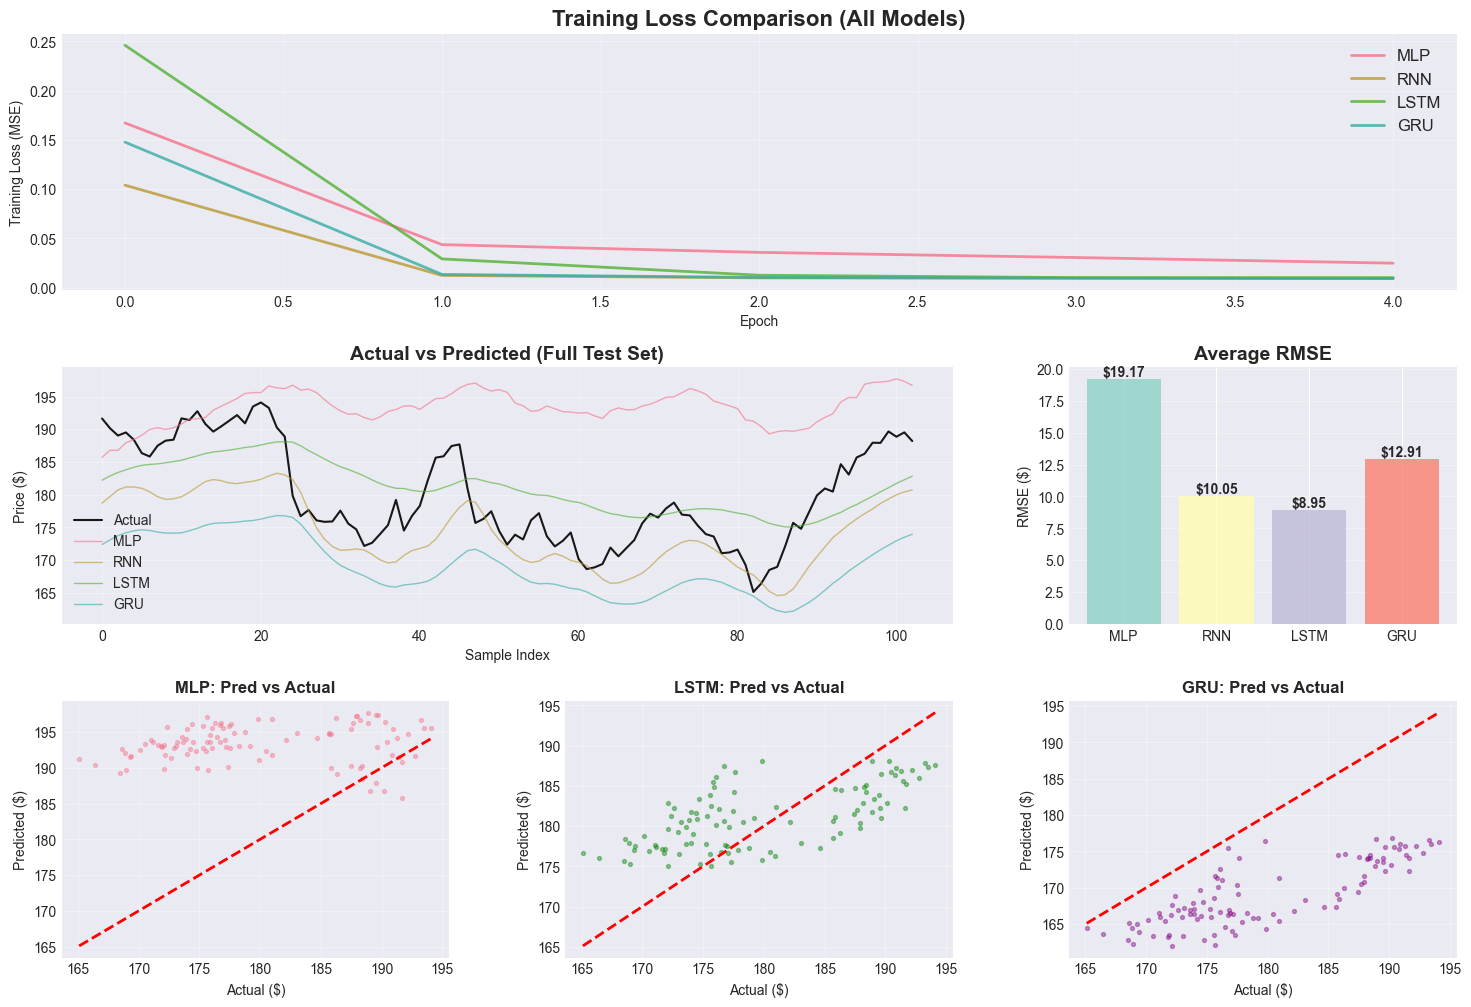


FINAL MODEL COMPARISON
Metric                         MLP             RNN             LSTM            GRU            
--------------------------------------------------------------------------------
Avg RMSE ($)                   19.172          10.045          8.948           12.906         
Avg MAE ($)                    17.183          8.130           7.684           10.512         
Correlation                    0.0931          0.8811          0.6487          0.8091         
Parameters                     16,153          53,017          70,297          152,601        
Final Val Loss                 0.0867          0.0188          0.0327          0.0161         

Best performing model: LSTM


In [252]:
# Comprehensive comparison: All 4 models - Actual vs Predicted
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Extract 1-day ahead predictions
mlp_pred_series = mlp_preds[:, 0]
rnn_pred_series = rnn_preds[:, 0]
lstm_pred_series = lstm_preds[:, 0]
gru_pred_series = gru_preds[:, 0]
actual_series = lstm_actuals[:, 0]

# Training curves
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(mlp_train_losses, label='MLP', linewidth=2, alpha=0.8)
ax1.plot(rnn_train_losses, label='RNN', linewidth=2, alpha=0.8)
ax1.plot(lstm_train_losses, label='LSTM', linewidth=2, alpha=0.8)
ax1.plot(gru_train_losses, label='GRU', linewidth=2, alpha=0.8)
ax1.set_title('Training Loss Comparison (All Models)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss (MSE)')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Actual vs Predicted - Full test set
ax2 = fig.add_subplot(gs[1, :2])
ax2.plot(actual_series, label='Actual', linewidth=1.5, alpha=0.9, color='black')
ax2.plot(mlp_pred_series, label='MLP', linewidth=1, alpha=0.6)
ax2.plot(rnn_pred_series, label='RNN', linewidth=1, alpha=0.6)
ax2.plot(lstm_pred_series, label='LSTM', linewidth=1, alpha=0.6)
ax2.plot(gru_pred_series, label='GRU', linewidth=1, alpha=0.6)
ax2.set_title('Actual vs Predicted (Full Test Set)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Price ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Average RMSE bar chart
ax3 = fig.add_subplot(gs[1, 2])
models = ['MLP', 'RNN', 'LSTM', 'GRU']
avg_rmse = [np.mean(mlp_rmse), np.mean(rnn_rmse), np.mean(lstm_rmse), np.mean(gru_rmse)]
colors = plt.cm.Set3(range(4))
bars = ax3.bar(models, avg_rmse, color=colors, alpha=0.8)
ax3.set_title('Average RMSE', fontsize=14, fontweight='bold')
ax3.set_ylabel('RMSE ($)')
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, avg_rmse):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'${val:.2f}', ha='center', va='bottom', fontweight='bold')

# Scatter plots for each model
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(actual_series, mlp_pred_series, alpha=0.4, s=8)
ax4.plot([actual_series.min(), actual_series.max()], [actual_series.min(), actual_series.max()], 'r--', lw=2)
ax4.set_title('MLP: Pred vs Actual', fontsize=12, fontweight='bold')
ax4.set_xlabel('Actual ($)')
ax4.set_ylabel('Predicted ($)')
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[2, 1])
ax5.scatter(actual_series, lstm_pred_series, alpha=0.4, s=8, color='green')
ax5.plot([actual_series.min(), actual_series.max()], [actual_series.min(), actual_series.max()], 'r--', lw=2)
ax5.set_title('LSTM: Pred vs Actual', fontsize=12, fontweight='bold')
ax5.set_xlabel('Actual ($)')
ax5.set_ylabel('Predicted ($)')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[2, 2])
ax6.scatter(actual_series, gru_pred_series, alpha=0.4, s=8, color='purple')
ax6.plot([actual_series.min(), actual_series.max()], [actual_series.min(), actual_series.max()], 'r--', lw=2)
ax6.set_title('GRU: Pred vs Actual', fontsize=12, fontweight='bold')
ax6.set_xlabel('Actual ($)')
ax6.set_ylabel('Predicted ($)')
ax6.grid(True, alpha=0.3)

plt.show()

# Final summary with correlations
param_counts = [
    sum(p.numel() for p in mlp_model.parameters()),
    sum(p.numel() for p in rnn_model.parameters()),
    sum(p.numel() for p in lstm_model.parameters()),
    sum(p.numel() for p in gru_model.parameters())
]

corr_mlp = np.corrcoef(actual_series, mlp_pred_series)[0, 1]
corr_rnn = np.corrcoef(actual_series, rnn_pred_series)[0, 1]
corr_lstm = np.corrcoef(actual_series, lstm_pred_series)[0, 1]
corr_gru = np.corrcoef(actual_series, gru_pred_series)[0, 1]

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(f"{'Metric':<30} {'MLP':<15} {'RNN':<15} {'LSTM':<15} {'GRU':<15}")
print("-"*80)
print(f"{'Avg RMSE ($)':<30} {np.mean(mlp_rmse):<15.3f} {np.mean(rnn_rmse):<15.3f} {np.mean(lstm_rmse):<15.3f} {np.mean(gru_rmse):<15.3f}")
print(f"{'Avg MAE ($)':<30} {np.mean(mlp_mae):<15.3f} {np.mean(rnn_mae):<15.3f} {np.mean(lstm_mae):<15.3f} {np.mean(gru_mae):<15.3f}")
print(f"{'Correlation':<30} {corr_mlp:<15.4f} {corr_rnn:<15.4f} {corr_lstm:<15.4f} {corr_gru:<15.4f}")
print(f"{'Parameters':<30} {param_counts[0]:<15,} {param_counts[1]:<15,} {param_counts[2]:<15,} {param_counts[3]:<15,}")
print(f"{'Final Val Loss':<30} {mlp_val_losses[-1]:<15.4f} {rnn_val_losses[-1]:<15.4f} {lstm_val_losses[-1]:<15.4f} {gru_val_losses[-1]:<15.4f}")
print("="*80)

# Find best model
best_idx = np.argmin(avg_rmse)
print(f"\nBest performing model: {models[best_idx]}")

### GRU vs LSTM Discussion

**Key insights:**
1. **Performance:** Often within 1-2% of each other
2. **Speed:** GRU is typically 15-25% faster
3. **Parameters:** GRU has ~25% fewer parameters
4. **Use case:** GRU for production, LSTM when you need maximum accuracy



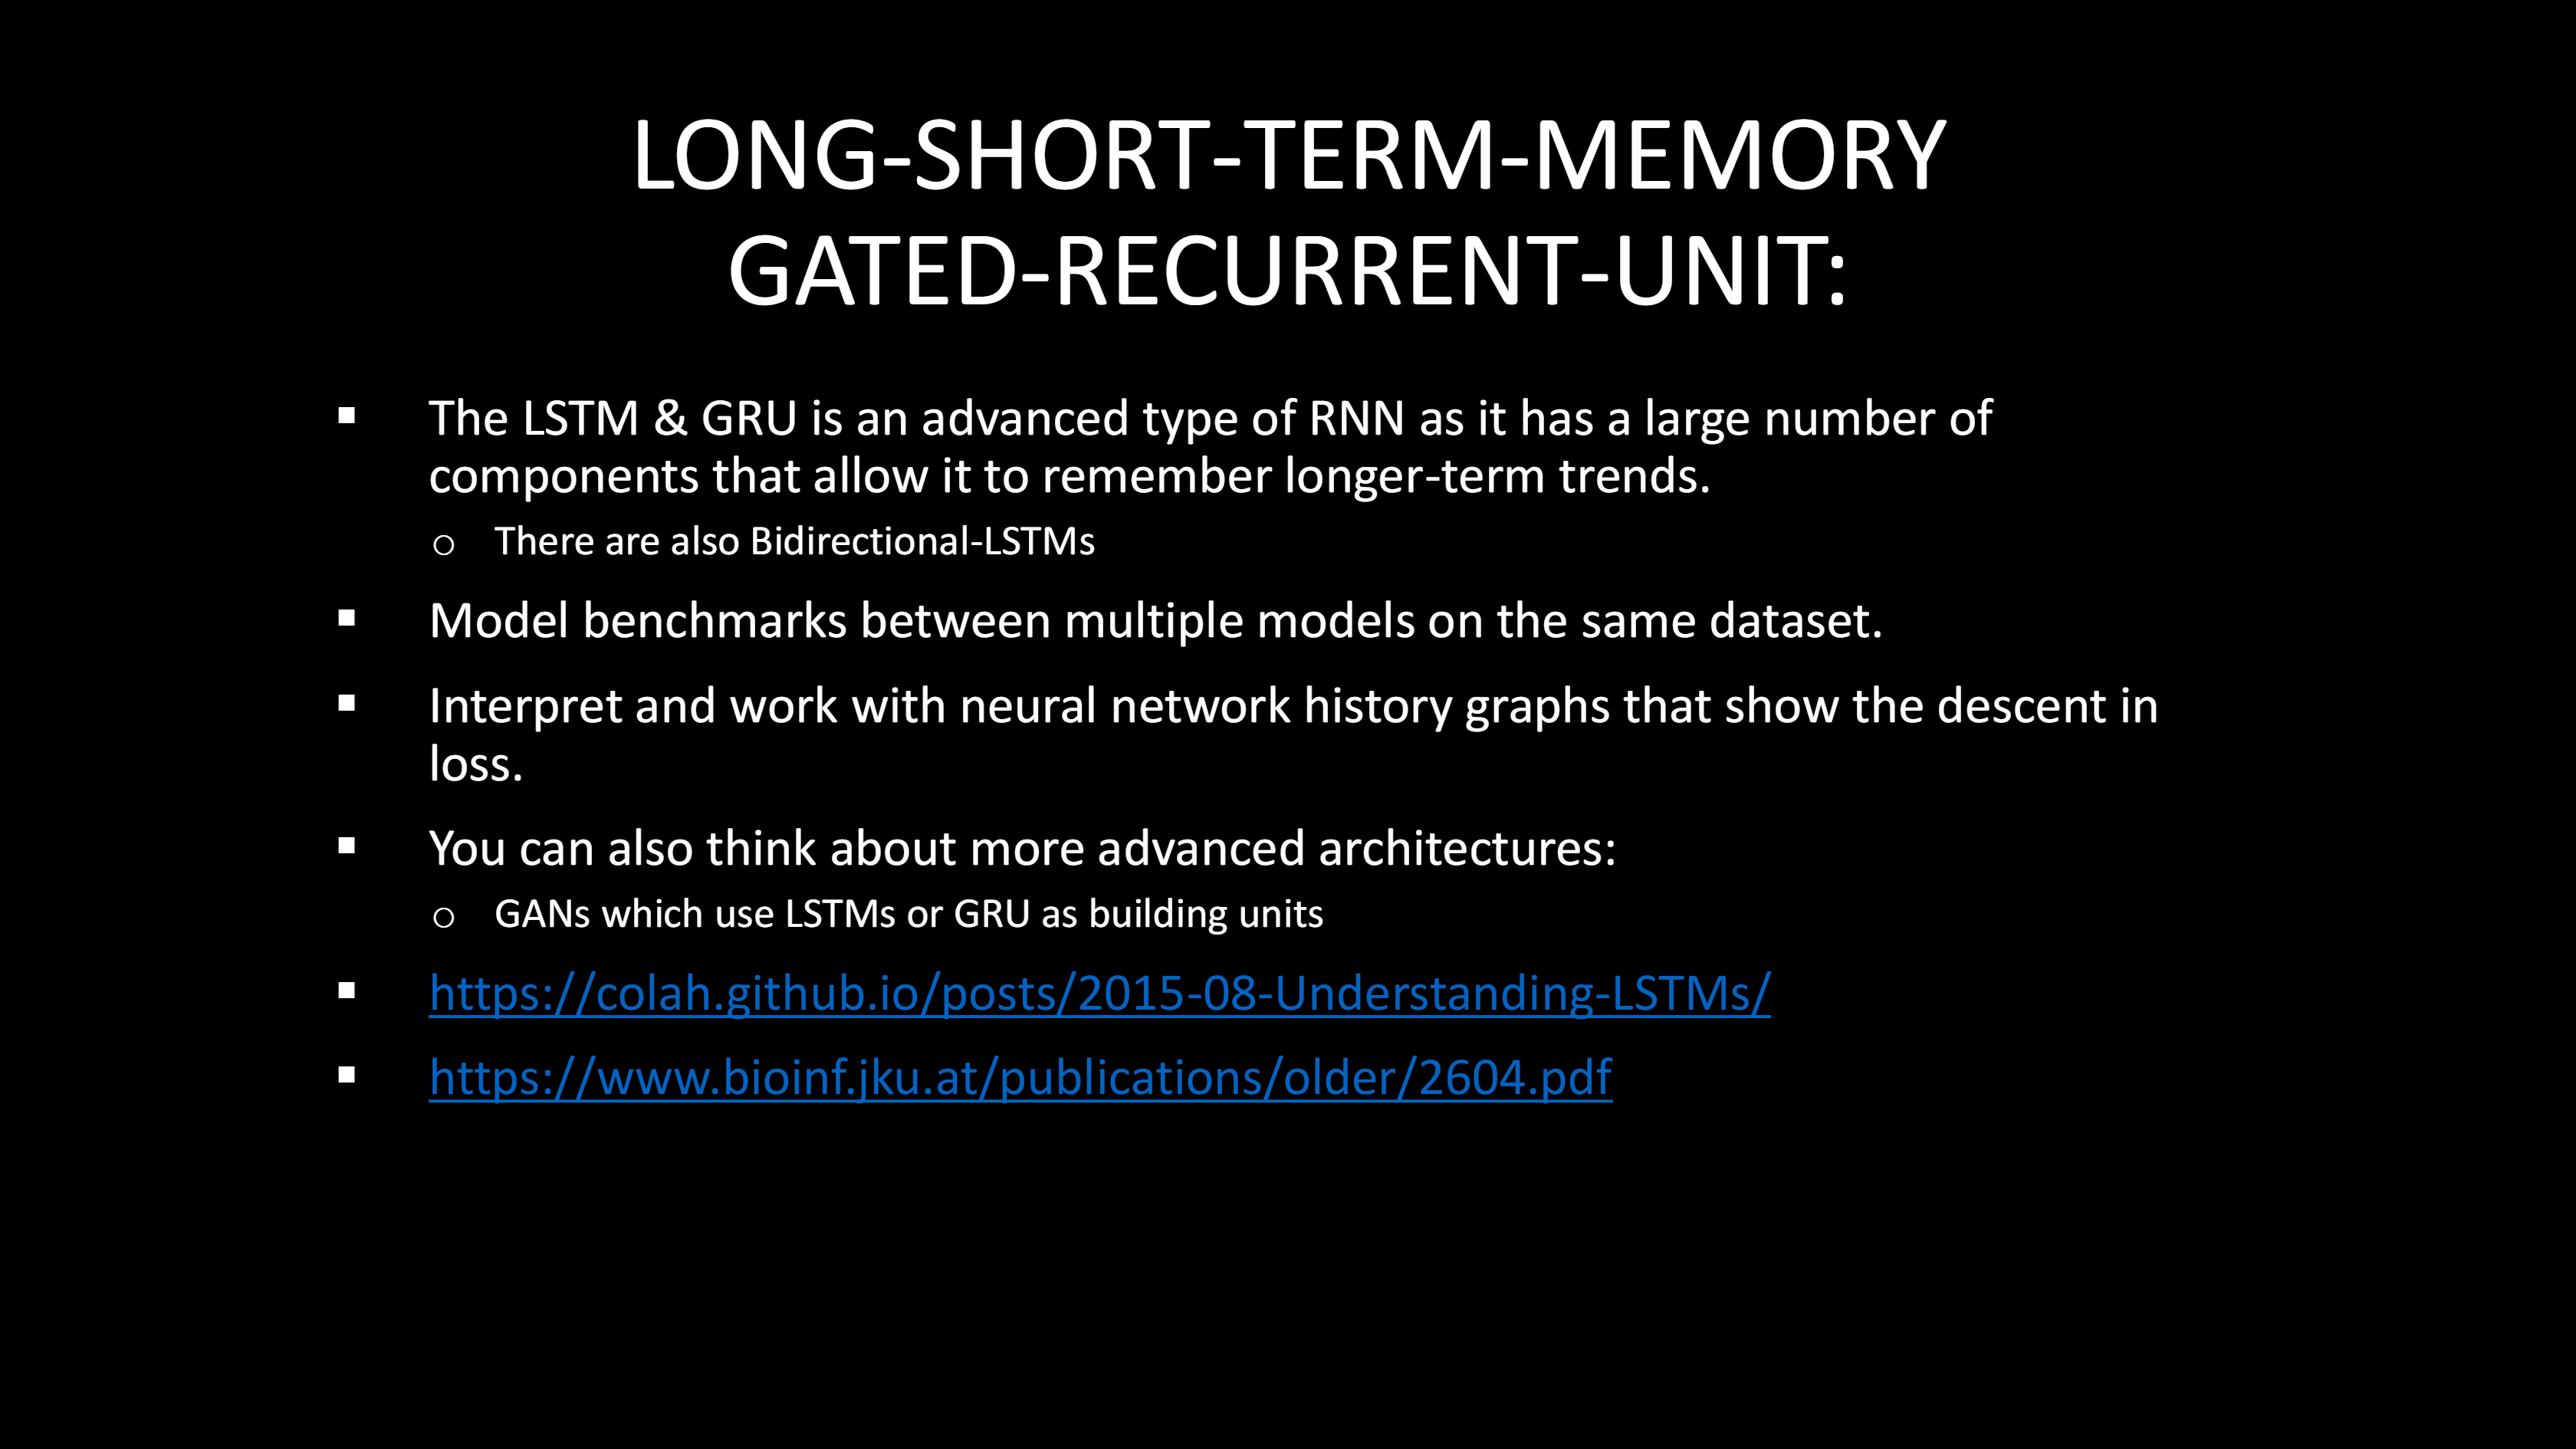

## Bonus: Quick Reference

### Model Complexity Comparison

**Equations**

**RNN**
$$
h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b)
$$

**LSTM**
$$
\begin{aligned}
f_t &= \sigma(W_f [h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(W_i [h_{t-1}, x_t] + b_i) \\
\tilde{C}_t &= \tanh(W_C [h_{t-1}, x_t] + b_C) \\
C_t &= f_t \odot C_{t-1} + i_t \odot \tilde{C}_t \\
o_t &= \sigma(W_o [h_{t-1}, x_t] + b_o) \\
h_t &= o_t \odot \tanh(C_t)
\end{aligned}
$$

**GRU**
$$
\begin{aligned}
z_t &= \sigma(W_z [h_{t-1}, x_t]) \\
r_t &= \sigma(W_r [h_{t-1}, x_t]) \\
\tilde{h}_t &= \tanh(W [r_t \odot h_{t-1},\, x_t]) \\
h_t &= (1 - z_t)\odot h_{t-1} + z_t \odot \tilde{h}_t
\end{aligned}
$$


---
## End of Lecture

### Key Takeaways

1. **MLPs:** Great baseline, but no temporal awareness
2. **RNNs:** Add sequential processing, but limited memory
3. **LSTMs:** Solve long-term dependencies with gates
4. **GRUs:** Simplified LSTMs with similar performance

### References

- LSTM: Hochreiter & Schmidhuber (1997)
- GRU: Cho et al. (2014)
- [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Illustrated Guide to LSTM's and GRU's: A step by step explanation](https://www.youtube.com/watch?v=8HyCNIVRbSU)

---

**Thank you!**